<center>
  <img src="great-white-shark.png" width=500>
</center>

## Introduction

Shark attacks are a rare occurrence but are becoming more frequent as coastal populations increase. The global shark attack data has been accumulated over the last few centuries and we can train a model to predict whether an attack is fatal or non-fatal.

Four models will be tuned then compared:
 - Random Forest
 - Support Vector Machine
 - Logistic Regression
 - Naive Bayes

## Importing the libraries

In [899]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import matplotlib

from sklearn import tree

from sklearn.compose import make_column_selector as col_selector
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler , StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

from sklearn.inspection import DecisionBoundaryDisplay

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 

## Choosing a Palette

In [901]:
palette_str = 'mako'
palette_str_r = 'mako_r'
palette = sns.color_palette(palette_str)
palette_r = sns.color_palette(palette_str_r)
cmap = sns.color_palette(palette_str, as_cmap=True)
cmap_r = sns.color_palette(palette_str_r, as_cmap=True)

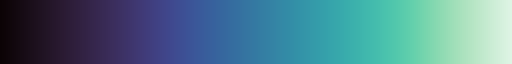

In [902]:
cmap

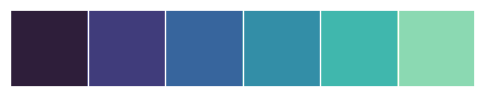

In [903]:
sns.palplot(palette)
plt.show()

In [904]:
print(palette.as_hex())

['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']


In [905]:
'''
Setting the CSS
'''
from IPython.display import HTML
style="""
<style>
    div.info { 
        background-color: #37659e;
        border-color: #40b7ad; 
        color: white;
        border-radius: 10px;
        width: 800px;
        padding: 2em;
        font-weight: bold;
        font-family: Verdana;
    }
</style>"""
HTML(style)

<div class='info'>This is an Info Box</div>

## Loading the data

In [908]:
"""
https://www.kaggle.com/datasets/gauravkumar2525/shark-attacks/data
"""
df = pd.read_csv("global_shark_attacks.csv")
df.shape

(6890, 13)

In [909]:
# Assign name for columns
columns = (["Date", "Year", "Type", "Country", "Area", "Location", "Activity", "Name", "Gender", "Age", "Fatal", "Time", 
            "Species"])
df.columns = columns

df.head()

,Date,Year,Type,Country,Area,Location,Activity,Name,Gender,Age,Fatal,Time,Species
0,2023-05-13,2023.0,Unprovoked,AUSTRALIA,South Australia,Elliston,Surfing,Simon Baccanello,M,46,Y,10h10,White shark
1,2023-04-29,2023.0,Unprovoked,AUSTRALIA,Western Australia,"Yallingup, Busselton",Swimming,male,M,NaN,N,11h20,1m shark
2,2022-10-07,2022.0,Unprovoked,AUSTRALIA,Western Australia,Port Hedland,Spearfishing,Robbie Peck,M,38,N,11h30,Bull shark
3,2021-10-04,2021.0,Unprovoked,USA,Florida,"Fort Pierce State Park, St. Lucie County",Surfing,Truman Van Patrick,M,25.0,N,NaN,NaN
4,2021-10-03,2021.0,Unprovoked,USA,Florida,"Jensen Beach, Martin County",Swimming,male,M,NaN,N,12h00,NaN


In [910]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6587 non-null   object 
 1   Year      6758 non-null   float64
 2   Type      6871 non-null   object 
 3   Country   6839 non-null   object 
 4   Area      6409 non-null   object 
 5   Location  6325 non-null   object 
 6   Activity  6304 non-null   object 
 7   Name      6670 non-null   object 
 8   Gender    6318 non-null   object 
 9   Age       3903 non-null   object 
 10  Fatal     6890 non-null   object 
 11  Time      3372 non-null   object 
 12  Species   3772 non-null   object 
dtypes: float64(1), object(12)
memory usage: 699.9+ KB


In [911]:
df.describe(include="O")

,Date,Type,Country,Area,Location,Activity,Name,Gender,Age,Fatal,Time,Species
count,6587,6871,6839,6409,6325,6304,6670,6318,3903,6890,3372,3772
unique,5558,11,215,862,4427,1553,5638,6,232,9,397,1560
top,1957-01-01,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,19.0,N,Afternoon,White shark
freq,11,5065,2522,1174,192,1112,669,5545,89,4804,215,192


## Initial Cleaning the data

Purpose: An initial cleaning to explore the data.

1. Remove duplicate rows.
2. Clean each feature by consolidating categories.

Note: Further cleaning will occur before model creation.

In [913]:
df.duplicated().sum()

3

In [914]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [915]:
df.isnull().sum()

Date         302
Year         132
Type          19
Country       51
Area         481
Location     565
Activity     586
Name         220
Gender       572
Age         2984
Fatal          0
Time        3515
Species     3116
dtype: int64

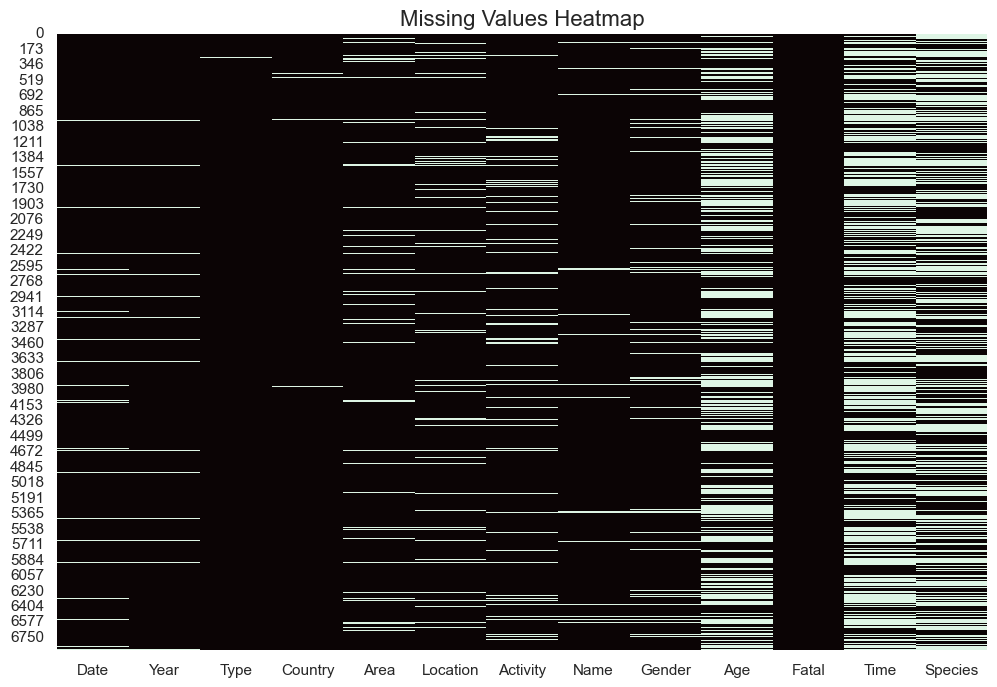

In [916]:
# Visualize missing values as a heatmap
# Source: https://medium.com/@HildaPosada/finding-and-visualizing-missing-data-in-python-using-missingno-and-seaborn-d4cf0452b9e9
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap=palette_str)
plt.title('Missing Values Heatmap', fontsize=16)
plt.savefig('missing-values-heatmap.png', dpi=400)
plt.show()

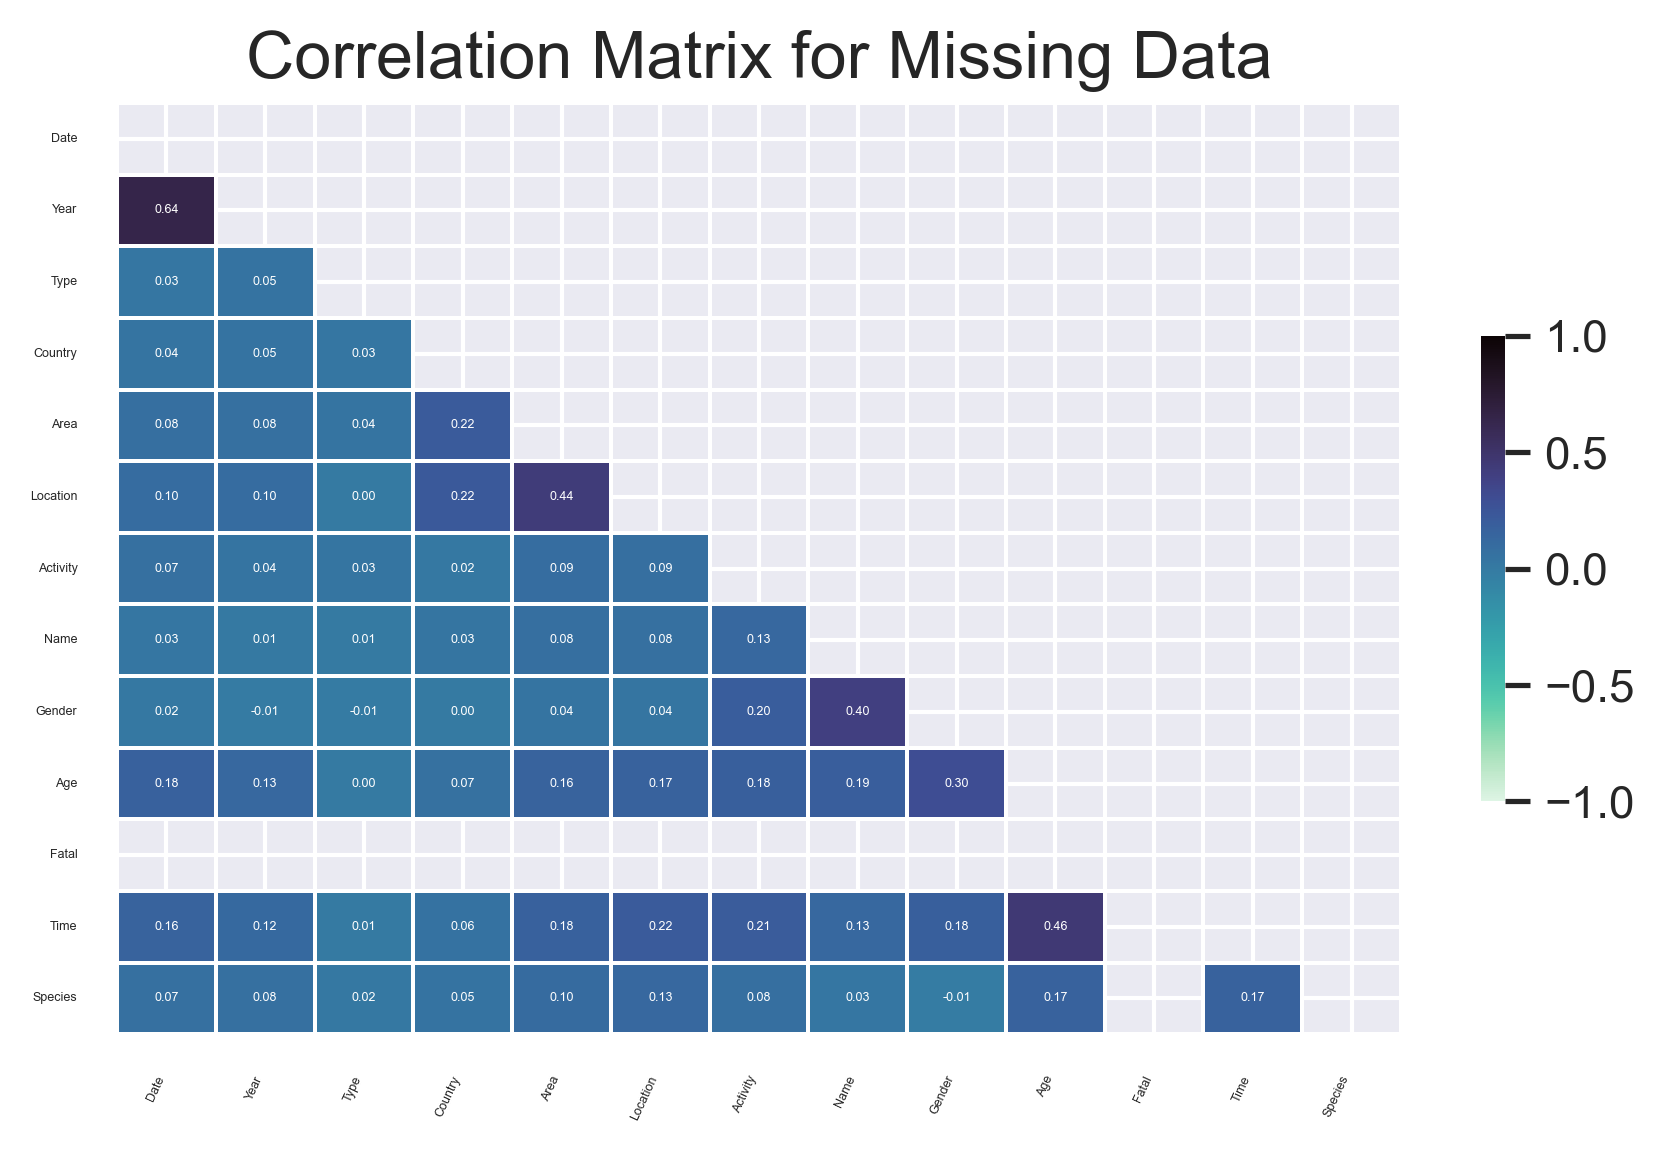

In [917]:
# Source: https://medium.com/@HildaPosada/finding-and-visualizing-missing-data-in-python-using-missingno-and-seaborn-d4cf0452b9e9

# Compute the correlation matrix of missing values
corr_matrix = df.isnull().corr()

# Set a threshold for filtering annotations
threshold = 0.8
mask_values = np.abs(corr_matrix) >= threshold

# Mask the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure with a high DPI for zooming

plt.figure(figsize=(6, 4), dpi=300)

# Create the heatmap with significant annotations
sns.heatmap(corr_matrix, mask=mask, cmap=palette_str_r, annot=True, fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": 0.5}, vmin=-1, vmax=1, 
            annot_kws={"size": 3})

# Wrap long column names
wrapped_columns = [textwrap.fill(col, 15) for col in corr_matrix.columns]

# Set x and y axis labels with smaller font sizes
plt.xticks(np.arange(len(wrapped_columns)) + 0.5, wrapped_columns, rotation=65, ha='right', fontsize=3)
plt.yticks(np.arange(len(wrapped_columns)) + 0.5, wrapped_columns, fontsize=3)

# Add title and adjust layout
plt.title('Correlation Matrix for Missing Data', fontsize=16)
plt.subplots_adjust(bottom=0.45)
plt.tight_layout()
plt.savefig('correlation-matrix-missing-data.png', dpi=400)
plt.show()

<div class='info'>

If Year is missing, Date is usually missing (0.64)


Location and Area 0.44 which will impact getting accurate GPS coordinates since only Country may be available.
</div>

In [919]:
"""
Cleaning Fatal

The Fatal data is binary either Yes or No.
"""
print("Value Counts (Before):")
print(df["Fatal"].value_counts())
print("Null: ", df["Fatal"].isnull().sum())

df["Fatal"] = df["Fatal"].replace("Y",1)
df["Fatal"] = df["Fatal"].replace("y",1)
df["Fatal"] = df["Fatal"].replace("F",1)
df["Fatal"] = df["Fatal"].replace("Y x 2",1)
df["Fatal"] = df["Fatal"].replace("N",0)
df["Fatal"] = df["Fatal"].replace("n",0)
df["Fatal"] = df["Fatal"].replace("Nq",0)  # A single record. Looked up name of victim. She survived.
df["Fatal"] = df["Fatal"].replace("2017.0",0) # Another single record. Looked up name and he survived.
df["Fatal"] = df["Fatal"].replace("UNKNOWN",None)
df.dropna(subset=["Fatal"], inplace=True)

print("\nValue Counts (After):")
print(df["Fatal"].value_counts())



Value Counts (Before):
Fatal
N          4802
Y          1447
UNKNOWN     630
F             3
y             1
Y x 2         1
n             1
2017.0        1
Nq            1
Name: count, dtype: int64
Null:  0

Value Counts (After):
Fatal
0    4805
1    1452
Name: count, dtype: int64


<div class='info'>
    The UNKNOWN Fatal rows were dropped.  Most were deaths with no confirmed shark involvement.
</div>

In [921]:
"""
Cleaning Date
"""
print("\nDate Types (Before): ")
print(df["Date"].apply(type).value_counts())

# Replace NaN with None
df["Date"] = df["Date"].replace("nan", None) 
print("Null Date: ", df["Date"].isnull().sum())

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("\nDate Types (After): ")
print(df["Date"].apply(type).value_counts())

df["Month Name"] = df["Date"].dt.month_name()
df["Month Name"].value_counts()

print("\nYear Types (Before): ")
print(df["Year"].apply(type).value_counts())
print("Null Year: ", df["Year"].isnull().sum())


Date Types (Before): 
Date
<class 'str'>      5979
<class 'float'>     278
Name: count, dtype: int64
Null Date:  278

Date Types (After): 
Date
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    5974
<class 'pandas._libs.tslibs.nattype.NaTType'>          283
Name: count, dtype: int64

Year Types (Before): 
Year
<class 'float'>    6257
Name: count, dtype: int64
Null Year:  127


<div class='info'>
    Leaving null dates alone for now because there is other valuable features in the records.
</div>

In [923]:
"""
Cleaning Type
"""
print("Value Counts (Before):")
print(df["Type"].value_counts())
print("Null: ", df["Type"].isnull().sum())

df = df.drop(df[df["Type"] == "Invalid"].index) # Remove invalid record
df = df.drop(df[df["Type"] == "Questionable"].index) # Remove Questionable record
#df["Type"] = df["Type"].replace("Boat","Watercraft") # Count Boat as a Watercraft
df["Type"] = df["Type"].replace("?","Other")
df["Type"] = df["Type"].replace("Unknown", "Other")
df["Type"] =  df["Type"].fillna("Other")
df["Type"] = df["Type"].astype(object)

print("\nValue Counts (After):")
print(df["Type"].value_counts())


Value Counts (Before):
Type
Unprovoked             4991
Provoked                625
Watercraft              340
Sea Disaster            236
Invalid                  25
Questionable             16
Boat                      7
Unverified                1
?                         1
Under investigation       1
Name: count, dtype: int64
Null:  14

Value Counts (After):
Type
Unprovoked             4991
Provoked                625
Watercraft              340
Sea Disaster            236
Other                    15
Boat                      7
Unverified                1
Under investigation       1
Name: count, dtype: int64


<div class='info'>
    Removed invalid and questionable records. Consolidate unknown types (?, Unknown, Other) into a single value (Other).
</div>

In [925]:
"""
Cleaning Gender
"""
print("Value Counts (Before):")
print(df["Gender"].value_counts())



df["Gender"] = df["Gender"].replace("M x 2","M")
df["Gender"] = df["Gender"].replace("nan", "Other") 
df["Gender"] = df["Gender"].replace("N", "Other") 
df["Gender"] = df["Gender"].replace(".", "Other") 
df["Gender"] = df["Gender"].replace("lli", "Other")
df["Gender"] = df["Gender"].replace("", "Other")
df["Gender"] = df["Gender"].replace("Unknown", "Other")

print("Null: ", df["Gender"].isnull().sum())

df["Gender"] = df["Gender"].fillna("Other")
df["Gender"] = df["Gender"].astype(object)

print("\nValue Counts (After):")
print(df["Gender"].value_counts())

Value Counts (Before):
Gender
M        5059
F         690
N           2
.           1
M x 2       1
lli         1
Name: count, dtype: int64
Null:  462

Value Counts (After):
Gender
M        5060
F         690
Other     466
Name: count, dtype: int64


<div class='info'>
    Consolidated Gender into M, F, Other. Filled NA with Other for now. Later, Other will be filled with mode of Non-Other.
</div>

In [927]:
"""
Cleaning Age
"""
def numeric_age(value):
    if not value:
        return None
    
    if value.isdigit():
        value = int(value)

    try:
        value = float(value)
    except ValueError:
        return None
    
    return value

print("Age type Counts (Before):")
print(df["Age"].apply(type).value_counts())

# Everything else with NaN replace with None
df = df.applymap(lambda x: None if pd.isna(x) else x)

df["Age"] = df["Age"].map(numeric_age)
#df["Age"] = df["Age"].fillna(df["Age"].median()) # Apply median to fill NA LATER
print("Null: ", df["Age"].isnull().sum())

print("\nAge type Counts (After):")
print(df["Age"].apply(type).value_counts())

Age type Counts (Before):
Age
<class 'str'>      3630
<class 'float'>    2586
Name: count, dtype: int64
Null:  2700

Age type Counts (After):
Age
<class 'float'>    6216
Name: count, dtype: int64


<div class='info'>
    Converted Age strings to numeric. Leaving NA alone for now. Later, it will be filled with the median Age.
</div>

In [929]:
"""
Cleaning Activity
"""
print("Value Counts (Before):")
print(df["Activity"].value_counts())

df["Activity"] =  df["Activity"].fillna("Other")
others = []

import re

def clean_activity_name(value):
    if not isinstance(value, str):
        others.append(value)
        return "Other"
    
    if re.search("spear", value.lower()):
        return "Spearfishing"
    elif re.search("(fishing|crabbing)", value.lower()):
        return "Fishing"
    elif re.search("(snorkeling|snorkling)", value.lower()):
        return "Snorkeling"
    elif re.search("(surf-skiing|surfskiing|surf skiing)", value.lower()):
        return "Surf-skiing"
    elif re.search("kayaking", value.lower()):
        return "Kayaking"
    elif re.search("filming", value.lower()):
        return "Filming"
    elif re.search("(surfing|body boarding|boogie|surf\s+board|surfboard|body-boarding)", value.lower()):
        return "Surfing"
    elif re.search("surf ski", value.lower()):
        return "Surf Skiing"
    elif re.search("(swim|treading)", value.lower()):
        return "Swimming"
    elif re.search("(diving|dived|dive)", value.lower()):
        return "Diving"
    elif re.search("(bathed|bathing)", value.lower()):
        return "Bathing"
    elif re.search("tsunami", value.lower()):
        return "Tsunami"
    elif re.search("outrigger", value.lower()):
        return "Outrigger"
    elif re.search("(kite\s+boarding|kite-boarding|kiteboarding)", value.lower()):
        return "Kite Boarding"
    elif re.search("(foil boarding|foil-boarding|kite foiling)", value.lower()):
        return "Foil Boarding"
    elif re.search("rowing", value.lower()):
        return "Rowing"
    elif re.search("floating", value.lower()):
        return "Floating"
    elif re.search("(sup|paddleboarding|paddleboard|paddle\s+boarding|paddle-boarding)", value.lower()):
        return "SUP"
    elif re.search("(wading|shallows|standing)", value.lower()):
        return "Wading"
    elif re.search("playing", value.lower()):
        return "Playing"
    elif re.search("canoeing", value.lower()):
        return "Canoeing"
    elif re.search("fell", value.lower()):
        return "Fell"
    elif re.search("jumping", value.lower()):
        return "Jumping"
    elif re.search("walking", value.lower()):
        return "Walking"
    elif re.search("shark", value.lower()):
        return "Direct Contact"
    elif re.search("(boat accident|capsize|sunk|sink|sank|overboard|adrift|torpedo|shipwrecked|wrecked|wreck|swamped|foundered|sea disaster|ship wreck)", value.lower()):
        return "Boat Accident"
    elif re.search("(airline|aircraft|crash)", value.lower()):
        return "Air Accident"
    else:
        others.append(value)
        return "Unknown description"
        
print("Null: ", df["Activity"].isnull().sum())
df["Activity"] = df["Activity"].apply(lambda x: " ".join(x.split())) # strip extra whitespace from string
#df["Activity"] = df["Activity"].map(clean_activity_name)
df["Activity"] = df["Activity"].astype(object)

print("\nValue Counts (After):")
print(df["Activity"].value_counts())

Value Counts (Before):
Activity
Surfing                                                      1062
Swimming                                                      900
Fishing                                                       469
Spearfishing                                                  351
Wading                                                        159
                                                             ... 
Lying in 2 feet of water                                        1
Free diving, collecting shells                                  1
Inspecting teeth of supposedly dead (hooked & shot) shark       1
Surfing & dangling foot in water amid baitfish                  1
Crew swimming alongside their anchored ship                     1
Name: count, Length: 1431, dtype: int64
Null:  0

Value Counts (After):
Activity
Surfing                                                      1062
Swimming                                                      900
Fishing                      

<div class='info'>
    
Major classification of Activity into consolidated categories. 
    
Activity is extremely important which we will see later. Certain activites look like prey behavior such as splashing, jumping, bathing and even swimming. 

Also, if the activity is indefensible or un-rescueable, the attack is more likely fatal. For example, being on a surfboard is more defensible than swimming in open water. Or being stranded at sea in open water.
</div>

In [931]:
#others

In [932]:
"""
Cleaning Country
"""
print("Value Counts (Before):")
print("Country: ", df["Country"].value_counts()[:10])

print("Null: ", df["Country"].isnull().sum())

df["Country"] = df["Country"].apply(lambda x: " ".join(x.split()) if not pd.isna(x) else x) # strip extra whitespace from string
df["Country"] = df["Country"].apply(lambda x: "Other" if pd.isna(x) else x.upper())
df["Country"] = df["Country"].astype(object)

print("\nValue Counts (After):")
print("Country: ", df["Country"].value_counts()[:10])

Value Counts (Before):
Country:  Country
USA                 2297
AUSTRALIA           1311
SOUTH AFRICA         529
PAPUA NEW GUINEA     131
NEW ZEALAND          128
BAHAMAS              124
BRAZIL               108
MEXICO                88
FIJI                  65
NEW CALEDONIA         64
Name: count, dtype: int64
Null:  43

Value Counts (After):
Country:  Country
USA                 2297
AUSTRALIA           1313
SOUTH AFRICA         530
PAPUA NEW GUINEA     131
NEW ZEALAND          129
BAHAMAS              124
BRAZIL               108
MEXICO                89
FIJI                  67
NEW CALEDONIA         64
Name: count, dtype: int64


<div class='info'>
Applied upper case to classify Country outliers since most countries are uppcased. Null is converted to Other since. Location and Area can be used for Geo coordinates.
</div>

In [934]:
"""
Cleaning Area
"""
print("Value Counts (Before):")
print("Area: ", df["Area"].value_counts()[:10])

print("Null: ", df["Area"].isnull().sum())
df["Area"] = df["Area"].apply(lambda x: " ".join(x.split()) if not pd.isna(x) else x) # strip extra whitespace from string
df["Area"] = df["Area"].apply(lambda x: "Other" if pd.isna(x) else x.upper())
df["Area"] = df["Area"].astype(object)

print("\nValue Counts (After):")
print("Area: ", df["Area"].value_counts()[:10])

Value Counts (Before):
Area:  Area
Florida                  1093
New South Wales           462
Queensland                313
Hawaii                    292
California                290
Western Australia         198
Western Cape Province     186
KwaZulu-Natal             175
Eastern Cape Province     155
South Carolina            149
Name: count, dtype: int64
Null:  418

Value Counts (After):
Area:  Area
FLORIDA                  1093
NEW SOUTH WALES           462
Other                     418
QUEENSLAND                313
HAWAII                    292
CALIFORNIA                290
WESTERN AUSTRALIA         199
WESTERN CAPE PROVINCE     186
KWAZULU-NATAL             175
EASTERN CAPE PROVINCE     156
Name: count, dtype: int64


<div class='info'>
Null is converted to Other since Location and Country can be used for Geo coordinates.
</div>

In [936]:
"""
Location
"""
print("Value Counts (Before):")
print("Location: ", df["Location"].value_counts()[:10])
print("Null: ", df["Location"].isnull().sum())

df["Location"] = df["Location"].apply(lambda x: " ".join(x.split()) if not pd.isna(x) else x) # strip extra whitespace from string
df["Location"] = df["Location"].apply(lambda x: "Other" if pd.isna(x) else x.upper())

print("\nValue Counts (After):")
print("Location: ", df["Location"].value_counts()[:10])

Value Counts (Before):
Location:  Location
New Smyrna Beach, Volusia County    189
Daytona Beach, Volusia County        34
Ponce Inlet, Volusia County          26
Melbourne Beach, Brevard County      20
Myrtle Beach, Horry County           19
Cocoa Beach, Brevard  County         18
Isle of Palms, Charleston County     16
Boa Viagem, Recife                   14
Piedade                              13
Cocoa Beach, Brevard County          13
Name: count, dtype: int64
Null:  493

Value Counts (After):
Location:  Location
Other                               493
NEW SMYRNA BEACH, VOLUSIA COUNTY    194
DAYTONA BEACH, VOLUSIA COUNTY        35
COCOA BEACH, BREVARD COUNTY          32
PONCE INLET, VOLUSIA COUNTY          26
MELBOURNE BEACH, BREVARD COUNTY      20
MYRTLE BEACH, HORRY COUNTY           19
ISLE OF PALMS, CHARLESTON COUNTY     18
BOA VIAGEM, RECIFE                   14
PIEDADE                              13
Name: count, dtype: int64


<div class='info'>
    Null is converted to Other since Area and Country can be used for Geo coordinates.
</div>

In [938]:
"""
Cleaning Species
"""
others = []
def clean_species(value):
    if not isinstance(value, str):
        #print("Not a string: ", value)
        others.append(value)
        return "Other"
    # Note: Order of conditional matters
    if re.search("sand", value.lower()):
        return "Sand Shark"
    elif re.search("(raggedtooth| ragged tooth)", value.lower()):
        return "Raggedtooth Shark"
    elif re.search("(bull|zambezi|zambesi|leucas)", value.lower()):
        return "Bull Shark"
    elif re.search("lemon", value.lower()):
        return "Lemon Shark"
    elif re.search("thresher", value.lower()):
        return "Thresher Shark"
    elif re.search("nurse", value.lower()):
        return "Nurse Shark"
    elif re.search("(hammerhead|hammer head)", value.lower()):
        return "Hammerhead Shark"
    elif re.search("(blacktip|black tip)", value.lower()):
        return "Blacktip Shark"
    elif re.search("(copper|bronze|whaler|narrowtooth)", value.lower()):
        return "Copper Shark"
    elif re.search("(whale|while shark)", value.lower()):
        return "Whale Shark"
    elif re.search("mako", value.lower()):
        return "Mako Shark"
    elif re.search("(leopard|leapord)", value.lower()):
        return "Leopard Shark"
    elif re.search("blue", value.lower()):
        return "Blue Shark"
    elif re.search("spinner", value.lower()):
        return "Spinner Shark"
    elif re.search("wobbegong", value.lower()):
        return "Wobbegong Shark"
    elif re.search("carpet", value.lower()):
        return "Carpet Shark"
    elif re.search("reef", value.lower()):
        return "Reef Shark" 
    elif re.search("(dusky|c. obscurus|carcharhinus obscurus)", value.lower()):
        return "Dusky Shark"   
    elif re.search("angel", value.lower()):
        return "Angel Shark" 
    elif re.search("shovelnose", value.lower()):
        return "Shovelnose Shark" 
    elif re.search("sharpnose", value.lower()):
        return "Sharpnose Shark" 
    elif re.search("(sevengill|seven-gill|seven gill)", value.lower()):
        return "Sevengill Shark"
    elif re.search("(galapagos|galapagensis)", value.lower()):
        return "Galapagos Shark"
    elif re.search("(grey|gray|Carcharhinus)", value.lower()):
        return "Gray Shark"
    elif re.search("(whitetip| white tip)", value.lower()):
        return "Whitetip Shark"
    elif re.search("white", value.lower()):
        return "White Shark"
    elif re.search("tiger", value.lower()):
        return "Tiger Shark"
    else:
        #print("No match: ", value)
        others.append(value)
        return "Unknown description"

print("Value Counts (Before):")
print(df["Species"].value_counts())
print("Null: ", df["Species"].isnull().sum())

df["Species"] = df["Species"].apply(lambda x: " ".join(x.split()) if not pd.isna(x) else x) # strip extra whitespace from string
#df["Species"] = df["Species"].map(clean_species)
df["Species"] = df["Species"].astype(object)
df["Species"] = df["Species"].apply(lambda x: "Other" if pd.isna(x) else x)

print("\nValue Counts (After):")
print(df["Species"].value_counts())

print("\nOther Species:")
print(df[df["Species"] == "Other"]["Fatal"].value_counts())

Value Counts (Before):
Species
White shark                                        184
Tiger shark                                         88
Bull shark                                          66
6' shark                                            43
4' shark                                            43
                                                  ... 
1.3 m [4'3] shark                                    1
1.5 to 1.8 m [5' to 6'] shark                        1
Caribbean reef shark, 1.2 m to 1.5 m [4' to 5']      1
Grey reef shark, 1.5 m                               1
Said to be a 7.6 m [25'] shark                       1
Name: count, Length: 1485, dtype: int64
Null:  3016

Value Counts (After):
Species
Other                                              3016
White shark                                         184
Tiger shark                                          88
Bull shark                                           66
4' shark                                             43
 

In [939]:
#others

<div class="info">
<ul>
    <li>There is a large number of missing Species even after consolidating.</li>
<li>Most invalid values are estimated shark size.</li>   

<li>This could be useful if the size can be extracted to form another feature.</li>
</ul>
</div>

In [941]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6216 entries, 0 to 6889
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5935 non-null   datetime64[ns]
 1   Year        6090 non-null   float64       
 2   Type        6216 non-null   object        
 3   Country     6216 non-null   object        
 4   Area        6216 non-null   object        
 5   Location    6216 non-null   object        
 6   Activity    6216 non-null   object        
 7   Name        6066 non-null   object        
 8   Gender      6216 non-null   object        
 9   Age         3516 non-null   float64       
 10  Fatal       6216 non-null   int64         
 11  Time        3187 non-null   object        
 12  Species     6216 non-null   object        
 13  Month Name  5935 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 728.4+ KB


## Exploring the data

In [943]:
def truncator(value):
    return value[0:6]
    
def top_10_count_plot(df, cols_list):
    ncols = 2
    nrows = int(len(cols_list) / 2)
    if len(cols_list)%2 > 0:
        nrows += 1

    
    sns.set()
    sns.set_palette(palette_r)
    figure, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(15,10))
    figure.suptitle("Top 10 Features by Percentage", fontsize=16)

    irow = 1
    icol = 1
    for col in cols_list:
        sns.countplot(ax=axes[irow-1,icol-1],
                      y=col, 
                      data=df, 
                      hue="Fatal", 
                      stat="percent", 
                      formatter=truncator, 
                      order=df[col].value_counts().iloc[:10].index)
        # Set next row, col
        if icol == 2:
            irow += 1
            icol = 1
        else:
            icol += 1

    plt.savefig('top10-percentages-hue-fatal.png', dpi=400)
    plt.show()
    

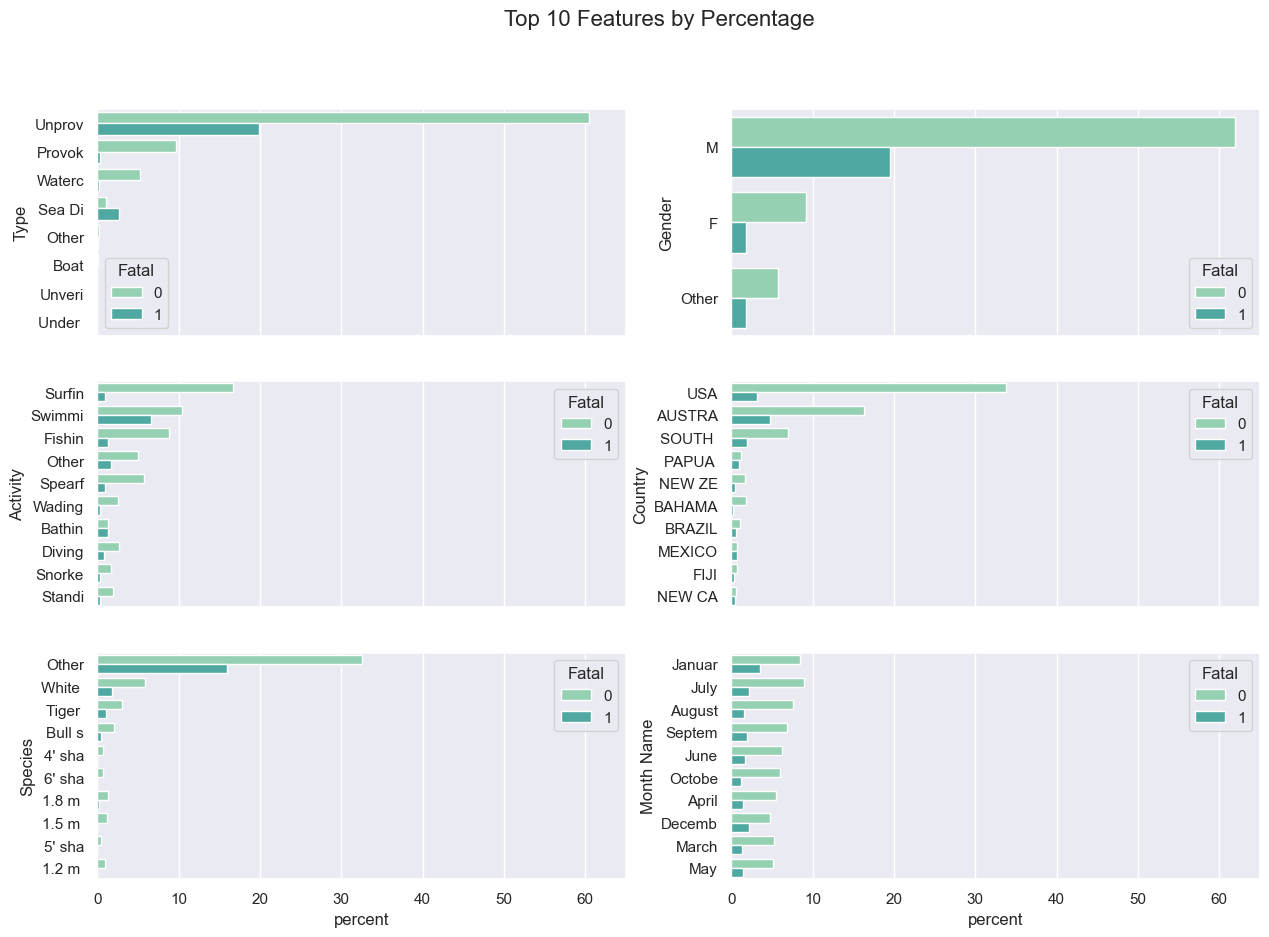

In [944]:
top_10_count_plot(df, ["Type", "Gender", "Activity", "Country", "Species", "Month Name"])

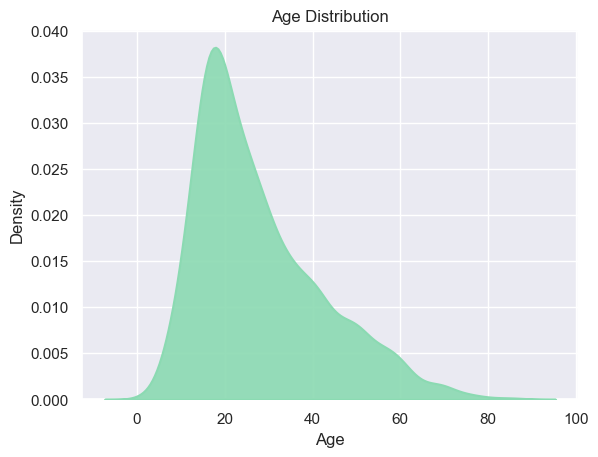

In [945]:
sns.set_palette(palette_r)
sns.kdeplot(df["Age"], fill=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
plt.title("Age Distribution")
plt.savefig('age-kdeplot.png', dpi=400)
plt.show()

<div class='info'>Age is skewed to the left in the data set</div>

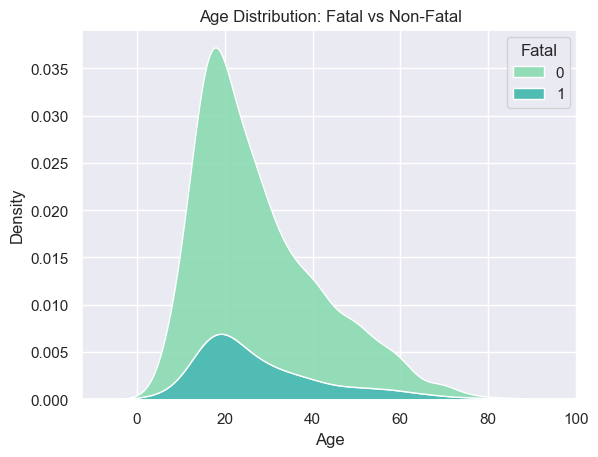

In [947]:
sns.set_palette(palette_r)
sns.kdeplot(data=df, x="Age", hue="Fatal", alpha=0.9, zorder=3, multiple="stack")   
plt.title("Age Distribution: Fatal vs Non-Fatal")
plt.savefig('age-kdeplot-with-fatal.png', dpi=400)
plt.show()

<div class="info">Age where attacks are Fatal is skewed only very slightly to the right of Non-Fatal.</div>

In [949]:
print("Overall Age")
print(df["Age"].describe())

fatal = df[df["Fatal"] == 1]
nfatal = df[df["Fatal"] == 0]

print("\nFatal Age")
print(fatal["Age"].describe())

print("\nNon_Fatal Age")
print(nfatal["Age"].describe())

Overall Age
count    3516.000000
mean       27.780432
std        14.334755
min         1.000000
25%        17.000000
50%        24.000000
75%        36.000000
max        87.000000
Name: Age, dtype: float64

Fatal Age
count    642.000000
mean      28.299065
std       14.842206
min        1.000000
25%       18.000000
50%       24.000000
75%       35.000000
max       84.000000
Name: Age, dtype: float64

Non_Fatal Age
count    2874.000000
mean       27.664579
std        14.218995
min         3.000000
25%        17.000000
50%        24.000000
75%        36.000000
max        87.000000
Name: Age, dtype: float64


<div class='info'>Age has a fair number of outliers -- especially older ages.  We should consider median instead of mean when filling missing values.</div>

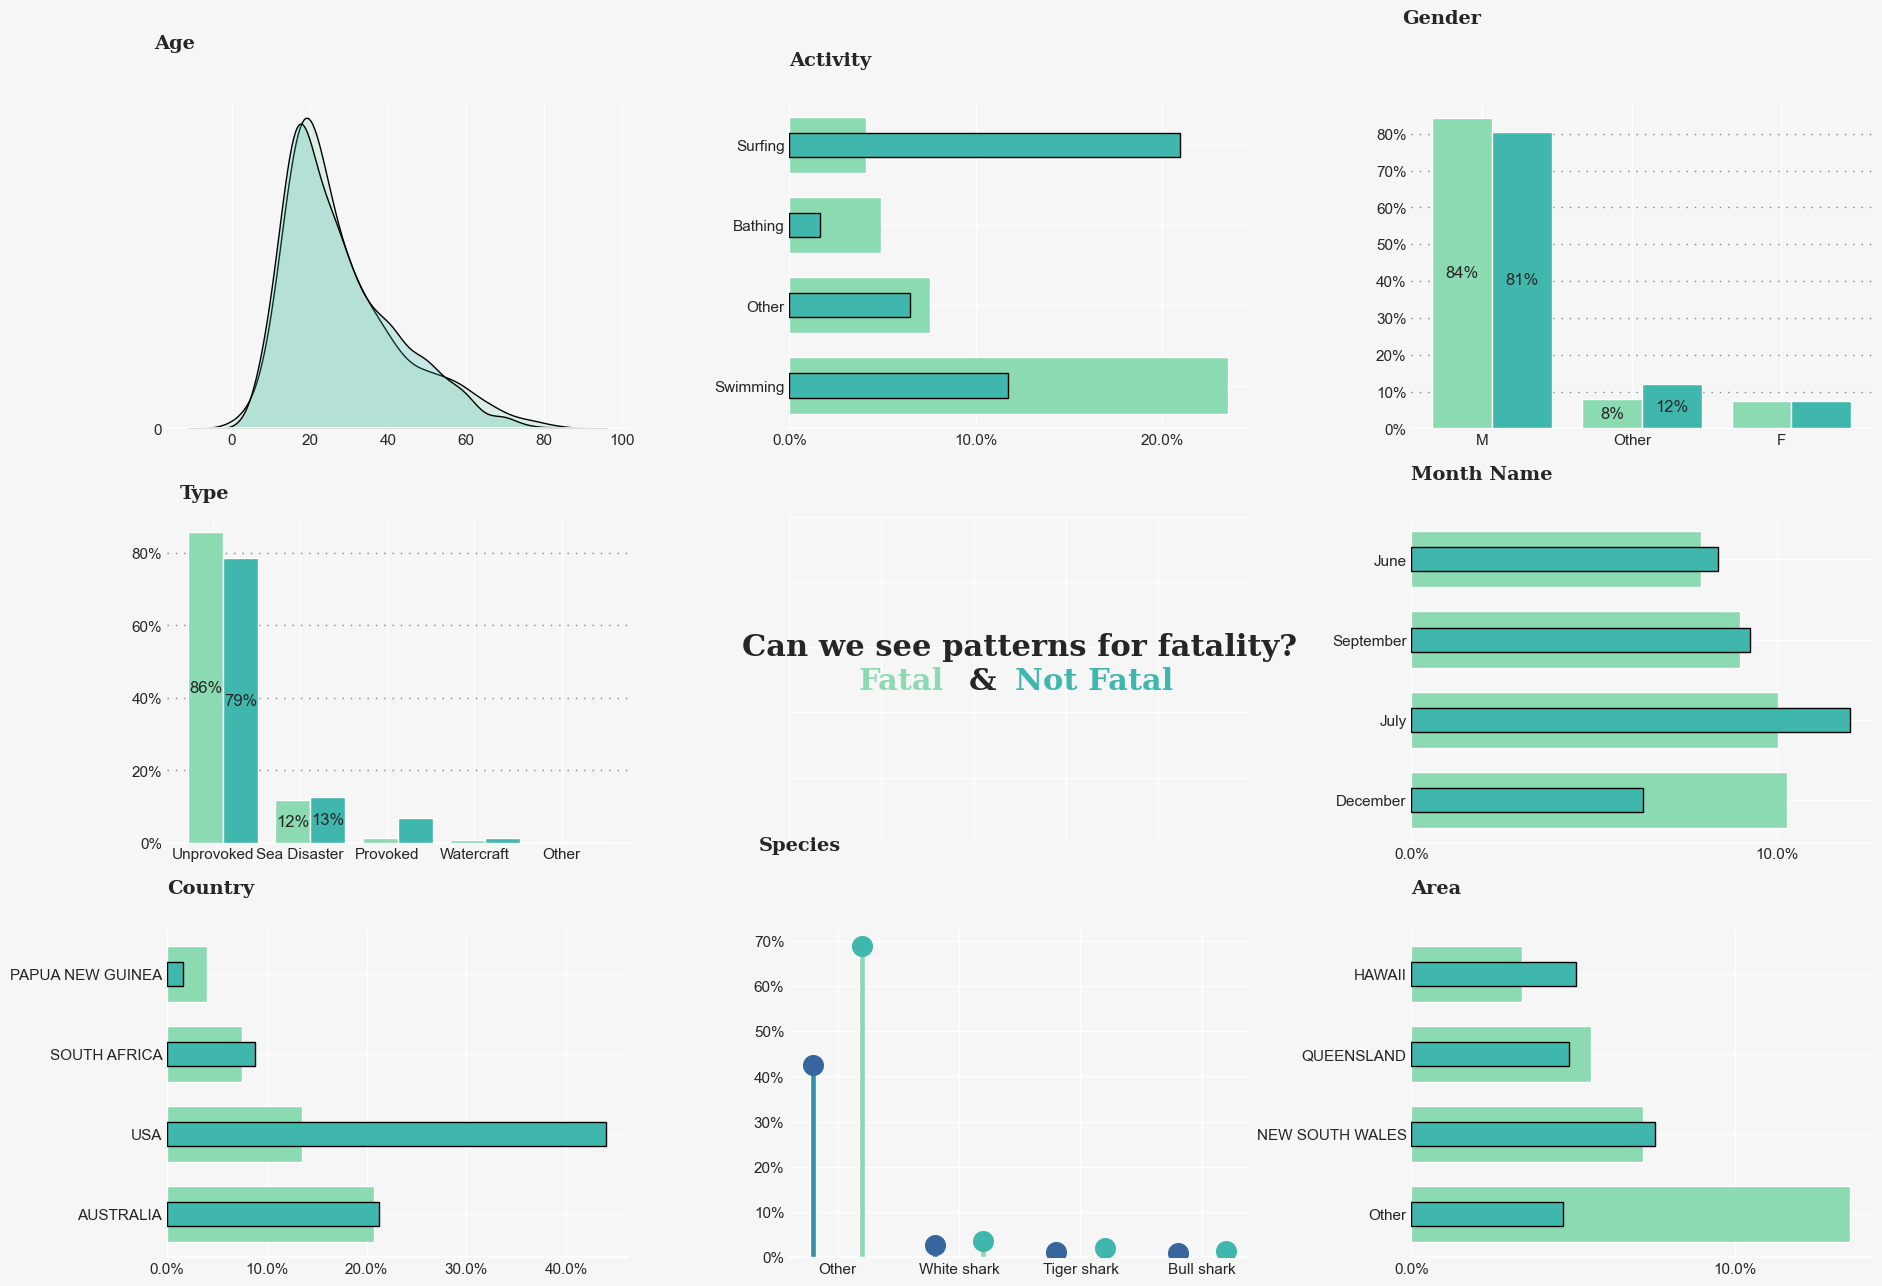

In [951]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fatal_color = "#0f4c81"
nfatal_color = "#9bb7d4"
fig.patch.set_facecolor(background_color) # figure background color

sns.set_palette(palette) 

# Plots
fatal = df[df["Fatal"] == 1]
nfatal = df[df["Fatal"] == 0]

"""
Age
"""
feature = "Age"
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(fatal[feature])
negative = pd.DataFrame(nfatal[feature])
sns.kdeplot(positive[feature], ax=ax0,shade=True, ec='black',label="positive")
sns.kdeplot(negative[feature], ax=ax0, shade=True, ec='black',label="negative")

ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, feature, fontsize=14, fontweight='bold', fontfamily='serif')


"""
Activity
"""
feature = "Activity"
positive = pd.DataFrame(fatal[feature].value_counts(dropna=True))


positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

top_index = positive.iloc[:4].index

ax1.text(0, 4, feature, fontsize=14, fontweight='bold', fontfamily='serif')
ax1.barh(top_index, positive['Percentage'][top_index], zorder=3, height=0.7)
ax1.barh(top_index, negative['Percentage'][top_index], zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

"""
Gender
"""
feature = "Gender"
positive = pd.DataFrame(fatal[feature].value_counts(dropna=True, sort=True))
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True, sort=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 110, "Gender", fontsize=14, fontweight='bold', fontfamily='serif')
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, width=0.4)

ticks = fatal[feature].dropna().unique()

ax2.set_xticks(x + 0.4 / len(ticks))
ax2.set_xticklabels(ticks)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), horizontalalignment='center', verticalalignment='center')

    

"""
Type
"""
feature = "Type"
positive = pd.DataFrame(fatal[feature].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

#print(positive.index)
#print(positive.head())

diff = list(set(negative.index) - set(positive.index))


negative = negative.drop(diff, axis=0)
diff = list(set(positive.index) - set(negative.index))
  

x = np.arange(len(positive))

ax3.text(-0.3, 95, feature, fontsize=14, fontweight='bold', fontfamily='serif')
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, width=0.4)

ticks = positive.index

ax3.set_xticks(x + 0.4 / len(ticks))
ax3.set_xticklabels(ticks)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2),  horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2),  horizontalalignment='center', verticalalignment='center')
    

"""
TITLE
"""

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'Can we see patterns for fatality?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif')

ax4.text(0.15,0.47,"Fatal", color="#8bdab2", fontweight="bold", fontfamily='serif', fontsize=22)
ax4.text(0.39,0.47,"&", fontweight="bold", fontfamily='serif', fontsize=22)
ax4.text(0.49,0.47,"Not Fatal", color="#40b7ad", fontweight="bold", fontfamily='serif', fontsize=22)


"""
Month Name
"""

feature = "Month Name"

positive = pd.DataFrame(fatal[feature].value_counts(dropna=True))


positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

top_index = positive.iloc[1:5].index

ax5.text(0, 4, feature, fontsize=14, fontweight='bold', fontfamily='serif')
ax5.barh(top_index, positive['Percentage'][top_index],  zorder=3, height=0.7)
ax5.barh(top_index, negative['Percentage'][top_index],  zorder=3,ec='black', height=0.3)
ax5.xaxis.set_major_formatter(mtick.PercentFormatter())
ax5.xaxis.set_major_locator(mtick.MultipleLocator(10))




"""
Countries
"""
feature = "Country"

positive = pd.DataFrame(fatal[feature].value_counts(dropna=True))


positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

top_index = positive.iloc[:4].index

    
ax6.text(0, 4, feature, fontsize=14, fontweight='bold', fontfamily='serif')
ax6.barh(top_index, positive['Percentage'][top_index], zorder=3, height=0.7)
ax6.barh(top_index, negative['Percentage'][top_index], zorder=3,ec='black', height=0.3)
ax6.xaxis.set_major_formatter(mtick.PercentFormatter())
ax6.xaxis.set_major_locator(mtick.MultipleLocator(10))

"""
Species
"""
feature = "Species"


positive = pd.DataFrame(fatal[feature].value_counts(dropna=True))


positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

top_index = positive.iloc[:4].index

ax7.bar(np.arange(len(top_index))+0.4, height=positive["Percentage"][top_index], zorder=3, width=0.05)
ax7.scatter(np.arange(len(top_index))+0.4, positive["Percentage"][top_index], zorder=3,s=200)
ax7.bar(top_index, height=negative["Percentage"][top_index], zorder=3, width=0.05)
ax7.scatter(top_index, negative["Percentage"][top_index], zorder=3,s=200)


ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(top_index))+0.4 / 2)
ax7.set_xticklabels(list(top_index),rotation=0)
ax7.text(-0.45, 90, "Species", fontsize=14, fontweight='bold', fontfamily='serif')



"""
Area
"""
feature = "Area"

usa = df[(df["Country"] == "USA")] 
#fatal =  usa[usa["Fatal"] == 1]
#nfatal = usa[usa["Fatal"] == 0]

positive = pd.DataFrame(fatal[feature].value_counts(dropna=True))


positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(nfatal[feature].value_counts(dropna=True))
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)

top_index = positive.iloc[:4].index

ax8.text(0, 4, "Area", fontsize=14, fontweight='bold', fontfamily='serif')
ax8.barh(top_index, positive['Percentage'][top_index], zorder=3, height=0.7)
ax8.barh(top_index, negative['Percentage'][top_index], zorder=3,ec='black', height=0.3)
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.xaxis.set_major_locator(mtick.MultipleLocator(10))


# tidy up



for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

plt.savefig('top4-percentages-by-feature-stacked-fatal.png', dpi=400)        
plt.show()

<div class="info">

Above plots are showing percentage of the feature being plotted.


For example, swimming make up 30% of fatal Activity and 15% of non-fatal Activity.

Unprovoked makes up 86% of fatal Types and 79% of non-fatal Types.
</div>

<div class='info'>

Notice that Species equal to 'Other' has a high fatality rate as compared to non-fatality. This represents missing Species values.  

If a person dies during the attack, there's less of a chance we would know what bit them.

Also notice that for Species equal to 'Unknown description', the fatality rate is lower than non-fatality.  Most of these are shark length estimates.  

If we have a shark length estimate, the attack was probably not fatal or there were witnesses to report it (nearshore).
</div>

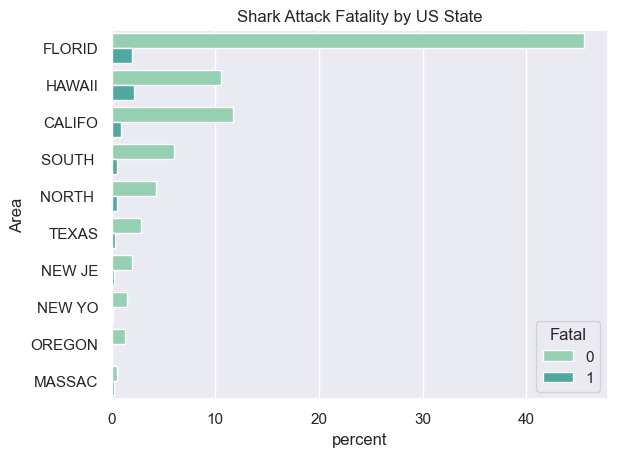

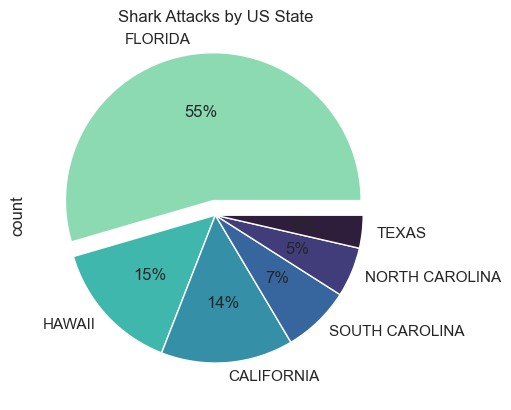

In [954]:
usa = df[(df["Country"] == "USA") & (df["Fatal"] != "Other")] 

sns.set_palette(palette_r)
sns.countplot(y="Area", 
              data=usa, 
              hue="Fatal", 
              stat="percent", 
              formatter=truncator, 
              order=usa["Area"].value_counts().iloc[:10].index)
plt.title("Shark Attack Fatality by US State")
plt.show()
explode = [0.1, 0, 0, 0, 0, 0] 
usa["Area"].value_counts().iloc[:6].plot.pie(legend=False,
                                             colors=sns.color_palette(palette_str_r),
                                             explode=explode,
                                             autopct="%1.0f%%")
plt.title("Shark Attacks by US State") 
plt.savefig('attacks-by-us-state.png', dpi=400) 
plt.show()

<div class='info'>Florida has an alarming percentage of US shark attacks. However, most are not fatal.</div>

## Correlation between features


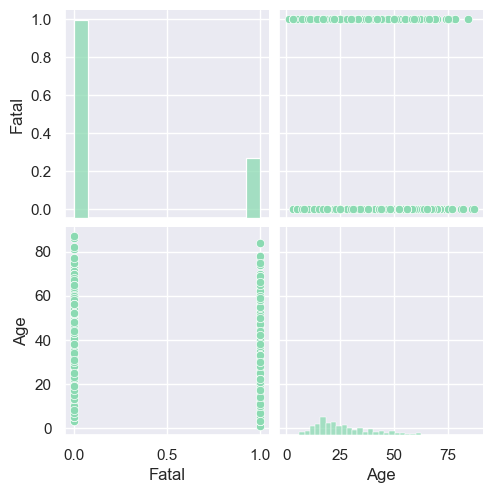

In [957]:
'''
Pairplot of Numeric only
'''
sns.set_palette(palette_r)
sns.pairplot(df[["Fatal", "Age"]])
plt.savefig('pairplot-numeric.png', dpi=400)
plt.show()

In [958]:
'''
Use LabelEncoder to encode categorical features
'''
df_corr = df.copy(deep=True)

categorical_features = ["Activity", "Area", "Country", "Gender", "Location", "Month Name", "Name", "Species", "Time", "Type"]

le = LabelEncoder()

# Encode categorical data
for cat in categorical_features:
    df_corr[cat] = le.fit_transform(df_corr[cat])


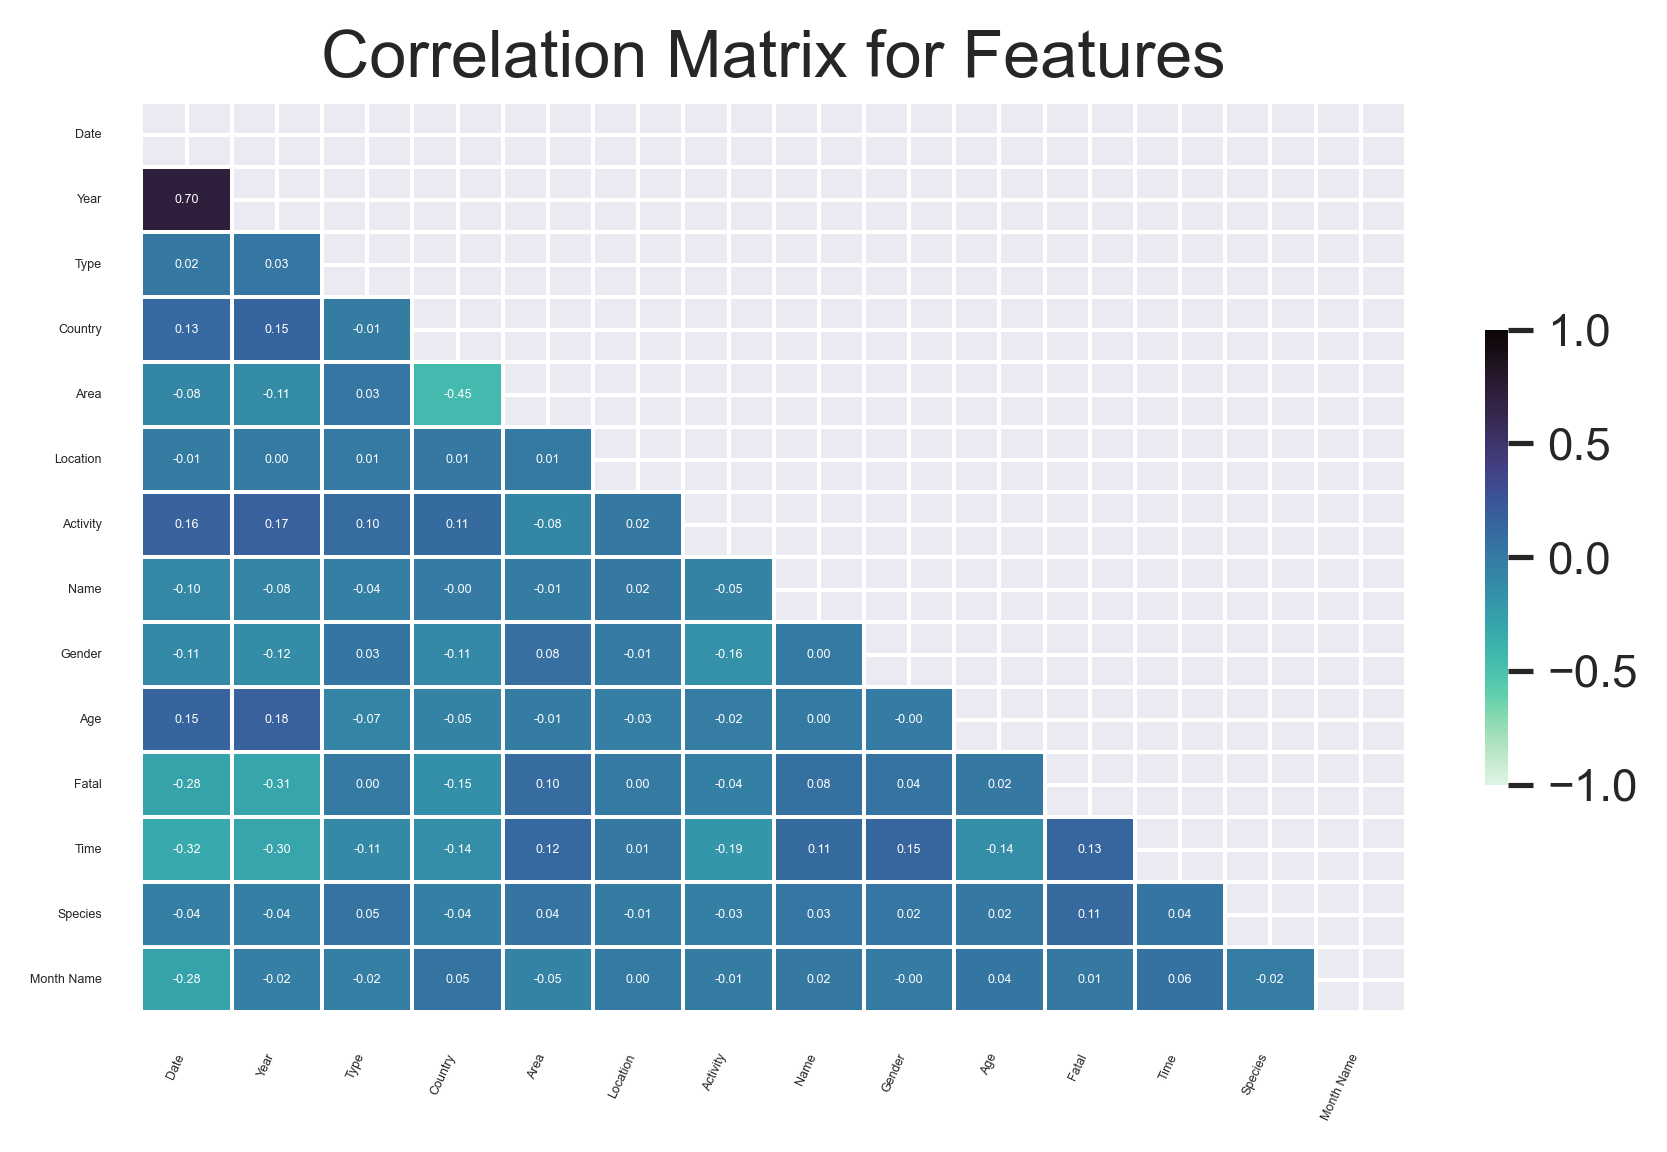

In [959]:
'''
Correlation Matric for all features
'''
# Source: https://medium.com/@HildaPosada/finding-and-visualizing-missing-data-in-python-using-missingno-and-seaborn-d4cf0452b9e9

# Compute the correlation matrix of missing values

corr_matrix = df_corr.corr()

# Set a threshold for filtering annotations
threshold = 0.8
mask_values = np.abs(corr_matrix) >= threshold

# Mask the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


# Set up the figure with a high DPI for zooming
plt.figure(figsize=(6, 4), dpi=300)

# Create the heatmap with significant annotations
sns.heatmap(corr_matrix, cmap=cmap_r, mask=mask, annot=True, fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": 0.5}, vmin=-1, vmax=1, 
            annot_kws={"size": 3})

# Wrap long column names
wrapped_columns = [textwrap.fill(col, 15) for col in corr_matrix.columns]

# Set x and y axis labels with smaller font sizes
plt.xticks(np.arange(len(wrapped_columns)) + 0.5, wrapped_columns, rotation=65, ha='right', fontsize=3)
plt.yticks(np.arange(len(wrapped_columns)) + 0.5, wrapped_columns, fontsize=3)

# Add title and adjust layout
plt.title('Correlation Matrix for Features', fontsize=16)
plt.subplots_adjust(bottom=0.45)
plt.tight_layout()
plt.savefig('correlation-matrix-all.png', dpi=400)
plt.show()

<div class='info'>

Most of the data is categorical which requires a Chi-Square Test. 
    
The strongest correlation is between Area and Country at -0.45.
Fatal with Year is -0.31. 
Time and Activity had a corelation of -0.21.
</div>

<div class='info'>
None of these features are strongly correlated.

Some are moderately correlated.  We can get better accuracy for Logistic Regression by limiting moderately correlated features. However, F1 is reduced and recall is poor.
</div>

## Final Cleaning of data
Choices:

- Gender, Month Name, Type, Year: "Other" values are set to the mode of Non-Other
- Filling Age NA to median (instead of mean due to outlier ages)

<div class='info'>
    
If 'Other' values are infrequent, the mode of the categorical data for Non-Other seems fine.


If 'Other' is frequent enough (Activity, Species), setting to the mode would generate too much synthetic data. This ends up negatively impacting the model scores.

There are 3 types of 'Other' in Species that I think the SVM poly kernel is picking up on.
<ul>
    <li>NAs</li>
    <li>'Other' as an included category in the data</li>
    <li>Estimated shark length instead of Species</li>
</ul>

Further insights:
<ul>
    <li>If you're bit by a shark, and survived, there's a low probabilty you know what bit you.</li>
    <li>Less if the attack was fatal, unless there was a witness, or a shark was seen in the area, or the bite mark can be associated.</li>
</div>

In [964]:
df["Type"] = df["Type"].replace("Unknown", "Other")
df["Type"] =  df["Type"].fillna("Other")
df["Area"] =  df["Area"].fillna("Other")

# If we set Species Other to mode, a vast majority (3/4) of the data would be Great White attacks which is a terrible approximation.
#df = df.drop(df[df["Species"] == "Other"].index)
# If we set Activity to the mode, about 1/4 of the data would become Surfing which is also terrible.
#df = df.drop(df[df["Activity"] == "Other"].index)
#df = df.drop(df[df["Month Name"] == "Other"].index)
#df = df.drop(df[df["Year"] == "Other"].index)
#df = df.drop(df[df["Type"] == "Other"].index)
#df = df.drop(df[df["Area"] == "Other"].index)

"""
Setting the more in-frequent 'Other' values to the mode of Non-Other values
"""
for i in ["Gender", "Month Name", "Type", "Year"]:
    mode = df[df[i] != "Other"][i].mode()[0]
    df[i] = df[i].replace("Other", mode)
    df[i].fillna(mode, inplace=True)

"""
Choosing median Age instead of mean because of outlier values.
"""
df["Age"] = df["Age"].fillna(df["Age"].median()) # Apply median to fill NA

In [965]:
df["Species"].value_counts()

Species
Other                                              3016
White shark                                         184
Tiger shark                                          88
Bull shark                                           66
4' shark                                             43
                                                   ... 
1.3 m [4'3] shark                                     1
1.5 to 1.8 m [5' to 6'] shark                         1
Caribbean reef shark, 1.2 m to 1.5 m [4' to 5']       1
Grey reef shark, 1.5 m                                1
Said to be a 7.6 m [25'] shark                        1
Name: count, Length: 1457, dtype: int64

In [966]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6216 entries, 0 to 6889
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5935 non-null   datetime64[ns]
 1   Year        6216 non-null   float64       
 2   Type        6216 non-null   object        
 3   Country     6216 non-null   object        
 4   Area        6216 non-null   object        
 5   Location    6216 non-null   object        
 6   Activity    6216 non-null   object        
 7   Name        6066 non-null   object        
 8   Gender      6216 non-null   object        
 9   Age         6216 non-null   float64       
 10  Fatal       6216 non-null   int64         
 11  Time        3187 non-null   object        
 12  Species     6216 non-null   object        
 13  Month Name  6216 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 728.4+ KB


In [967]:
x = df[["Activity", "Age", "Area", "Country", "Gender", "Location", "Month Name", "Species", "Type", "Year" ]]

print(x.info())

numeric_features = ["Age", "Year"]
categorical_features = ["Activity", "Area", "Country", "Gender", "Location", "Month Name", "Species", "Type"]

target = df["Fatal"]

<class 'pandas.core.frame.DataFrame'>
Index: 6216 entries, 0 to 6889
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Activity    6216 non-null   object 
 1   Age         6216 non-null   float64
 2   Area        6216 non-null   object 
 3   Country     6216 non-null   object 
 4   Gender      6216 non-null   object 
 5   Location    6216 non-null   object 
 6   Month Name  6216 non-null   object 
 7   Species     6216 non-null   object 
 8   Type        6216 non-null   object 
 9   Year        6216 non-null   float64
dtypes: float64(2), object(8)
memory usage: 534.2+ KB
None


## Creating the Models

Next, a Scaler will be chosen for the numeric data.  

The choices used will be:
 - StandardScaler
 - MinMaxScaler
 - RobustScaler

This will help fine tune the model.

OneHotEncoder is being used to encode the categorical data.

Since the data is imbalanced in favor of Non-Fatal (by over 3:1), I will use class weights to train the models.

I chose not to use SMOTE as it is not recommended as a best practice.

<div class='info'>
<b>Score choice:</b>
<ul>
    <li>Accuracy measures the overall correctness of the model's predictions.</li>
    <li>Precision and recall focus on the quality of positive and negative predictions, respectively.</li>
    <li>F1 provides a balance between precision and recall, making it a more comprehensive metric for evaluating classification models</li>
</ul>
</br></br>
I am using F1 score here.</div>

<div class='info'>
Imbalanced data - undersampling:

Fatal vs Non-Fatal is imbalanced 1/3.

Chose class_weight over SMOTE or manual undersampling because it is known to perform better if the imbalance isn't too high (less than 95%)

A good undersampling choice is supposed to help the SVM models perform better.
</div>

In [1013]:
"""
Setup Scaler Comparison for numeric feaure: Age

Using OneHotEncoder for the other categorical features.
"""
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

results = {}
results['RF'] = {}
results['SVM'] = {}
results['LOGR'] = {}

print("Mean F1 scores:")
for scaler in scalers:
    ct = ColumnTransformer([('num', scaler, numeric_features),
                            ('cat', OneHotEncoder(), categorical_features)])

    X_trans = ct.fit_transform(x).toarray()
            
    x_train, x_test, y_train, y_test = train_test_split(X_trans, target, test_size=0.2, random_state=42)

    # Handle fatal imbalance
    #
    # fatal_0:  3812
    # fatal_1:  1160
    # ratio:  3.286206896551724
    count_fatal_0 = y_train.value_counts()[0]
    count_fatal_1 = y_train.value_counts()[1]
    ratio = count_fatal_0/count_fatal_1


    rf_pipeline = Pipeline(steps = [('RF',RandomForestClassifier(class_weight={0:1, 1:ratio}, random_state=42))])
    svm_pipeline = Pipeline(steps = [('SVM',SVC(class_weight={0:1, 1:ratio}, random_state=42))])
    logreg_pipeline = Pipeline(steps = [('LR',LogisticRegression(class_weight={0:1, 1:ratio}, random_state=42))])

    # Calculate the mean scores
    rf_f1_score = cross_val_score(rf_pipeline,x_train,y_train,cv=10,scoring='f1', n_jobs=-1)
    svm_f1_score = cross_val_score(svm_pipeline,x_train,y_train,cv=10,scoring='f1', n_jobs=-1)
    logreg_f1_score = cross_val_score(logreg_pipeline,x_train,y_train,cv=10,scoring='f1')

    # Save for later
    results['RF'][scaler.__class__.__name__] = rf_f1_score
    results['SVM'][scaler.__class__.__name__] = svm_f1_score
    results['LOGR'][scaler.__class__.__name__] = logreg_f1_score
    
    print("\nScaler: ", scaler.__class__.__name__)
    print('Random Forest mean :',rf_f1_score.mean())
    print('SVM mean :',svm_f1_score.mean())
    print('Logistic Regression mean :',logreg_f1_score.mean())

Mean F1 scores:

Scaler:  StandardScaler
Random Forest mean : 0.5165651257235896
SVM mean : 0.6352818563942136
Logistic Regression mean : 0.6195997549260637

Scaler:  MinMaxScaler
Random Forest mean : 0.5187434533100556
SVM mean : 0.6182341259163169
Logistic Regression mean : 0.6180337289833068

Scaler:  RobustScaler
Random Forest mean : 0.5179026330174952
SVM mean : 0.6301765928305985
Logistic Regression mean : 0.6182808691207217


<div class='info'>
Logistic Regression won this time.
    
Choosing MinMaxScaler to scale the numeric data.
</div>


In [339]:
"""
Setting the scalers for each pipeline
"""

ct_standard = ColumnTransformer([('num', StandardScaler(), numeric_features),
                               ('cat', OneHotEncoder(), categorical_features)])

ct_robust = ColumnTransformer([('num', RobustScaler(), numeric_features),
                               ('cat', OneHotEncoder(), categorical_features)])

ct_minmax = ColumnTransformer([('num', MinMaxScaler(), numeric_features),
                                ('cat', OneHotEncoder(), categorical_features)])

X_trans_standard = ct_standard.fit_transform(x).toarray()
X_trans_robust = ct_robust.fit_transform(x).toarray()
X_trans_minmax = ct_minmax.fit_transform(x).toarray()

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(X_trans_standard, target, test_size=0.2, random_state=42)
x_train_robust, x_test_robust, y_train_robust, y_test_robust = train_test_split(X_trans_robust, target, test_size=0.2, random_state=42)
x_train_minmax, x_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_trans_minmax, target, test_size=0.2, random_state=42)

# Handle fatal imbalance
#
# fatal_0:  3812
# fatal_1:  1160
# ratio:  3.286206896551724
count_fatal_0 = y_train_minmax.value_counts()[0]
count_fatal_1 = y_train_minmax.value_counts()[1]
ratio_minmax = count_fatal_0/count_fatal_1

count_fatal_0 = y_train_robust.value_counts()[0]
count_fatal_1 = y_train_robust.value_counts()[1]
ratio_robust = count_fatal_0/count_fatal_1

count_fatal_0 = y_train_standard.value_counts()[0]
count_fatal_1 = y_train_standard.value_counts()[1]
ratio_standard = count_fatal_0/count_fatal_1

# for RandomForest
x_train_rf = x_train_minmax
x_test_rf = x_test_minmax
y_train_rf = y_train_minmax
y_test_rf = y_test_minmax
ratio_rf = ratio_minmax

# for SVM
x_train_svm = x_train_minmax
x_test_svm = x_test_minmax
y_train_svm = y_train_minmax
y_test_svm = y_test_minmax
ratio_svm = ratio_minmax

# for LogisticRegression
x_train_logreg = x_train_minmax
x_test_logreg = x_test_minmax
y_train_logreg = y_train_minmax
y_test_logreg = y_test_minmax
ratio_logreg = ratio_minmax

# Setup the pipelines
rf_pipeline = Pipeline(steps = [('RF',RandomForestClassifier(class_weight={0:1, 1:ratio_rf}, random_state=42))])
svm_pipeline = Pipeline(steps = [('SVM',SVC(class_weight={0:1, 1:ratio_svm}, random_state=42))])
logreg_pipeline = Pipeline(steps = [('LR',LogisticRegression(class_weight={0:1, 1:ratio_logreg}, random_state=42))])

## Unseen Test data

In [342]:
rf_pipeline.fit(x_train_rf,y_train_rf)
svm_pipeline.fit(x_train_svm,y_train_svm)
logreg_pipeline.fit(x_train_logreg,y_train_logreg)

rf_pred   =rf_pipeline.predict(x_test_rf)
svm_pred  = svm_pipeline.predict(x_test_svm)
logreg_pred   = logreg_pipeline.predict(x_test_logreg)

rf_cm  = confusion_matrix(y_test_rf,rf_pred )
svm_cm = confusion_matrix(y_test_svm,svm_pred)
logreg_cm  = confusion_matrix(y_test_logreg,logreg_pred )

rf_f1  = f1_score(y_test_rf,rf_pred)
svm_f1 = f1_score(y_test_svm,svm_pred)
logreg_f1  = f1_score(y_test_logreg,logreg_pred)

In [343]:
print('Mean F1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean F1 scores:
RF mean : 0.4878048780487805
SVM mean : 0.636085626911315
LR mean : 0.6201550387596899


<div class='info'>

SVM had the best F1 score with unseen test data
</div>

## Tuning RandomForest

Now tuning for RandomForest will be using GridSearchCV.

In [348]:
rf_grid = RandomForestClassifier(class_weight={0:1, 1:ratio_rf}, random_state=42)
gr_space = { 
    'n_estimators': [50, 100, 200, 500],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, None],
    'bootstrap': [True, False],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rf_grid, gr_space, cv = 5, scoring='accuracy', verbose=1, n_jobs=-1)

In [350]:
grid.fit(x_train_rf, y_train_rf)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1,
                                                            1: 3.286206896551724},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='accuracy', verbose=1)

In [351]:
grid.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_split': 10,
 'n_estimators': 100}

In [352]:
grid.best_score_

0.8159720129824171

<div class='info'>
    
Optimized hyperparameters are:
<ul>
    <li>bootstrap:        True</li>
    <li>criterion:        'gini'</li>
    <li>max_depth:         None</li>
    <li>max_features:      'log2'</li>
    <li>min_samples_split: 5</li>
    <li>n_estimators:      100</li>
</ul>
</div>

In [397]:
"""
Use the best parameters here
"""
rfc = RandomForestClassifier(class_weight={0:1, 1:ratio_rf}, 
                             random_state=42)

rfc.fit(x_train_rf,y_train_rf)

rfc_tuned_pred = rfc.predict(x_test_rf)

In [399]:
print(classification_report(y_test_rf,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_rf,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test_rf,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       965
           1       0.64      0.39      0.49       279

    accuracy                           0.81      1244
   macro avg       0.74      0.67      0.69      1244
weighted avg       0.80      0.81      0.80      1244

Accuracy Score:  0.8143086816720257
F1 Score:  0.4878048780487805


## Tuning Logistic Regression

Let's try tuning Logistc Regression to compare.

In [169]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

log_param_grid = {'penalty': penalty, 
                  'C': C,
                  'solver': solvers }
logreg = LogisticRegression(class_weight={0:1, 1:ratio_logreg}, random_state=42)
grid = GridSearchCV(logreg,log_param_grid)

In [171]:
grid.fit(x_train_logreg,y_train_logreg)

GridSearchCV(estimator=LogisticRegression(class_weight={0: 1,
                                                        1: 3.286206896551724},
                                          random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [177]:
grid.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

In [179]:
grid.best_score_

0.8041056388582752

<div class='info'> 
    
Tuned hyperparameters are:
    
{'C': 10, 'penalty': 'l1', 'solver': 'saga'}
</div>


In [360]:
"""
Using best params:
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
"""
logreg_pipeline = Pipeline(steps = [('LR',LogisticRegression(class_weight={0:1, 1:ratio_logreg}, C=10,penalty='l1',solver='saga', random_state=42))])

logreg_pipeline.fit(x_train_logreg,y_train_logreg)

logreg_tuned_pred   = logreg_pipeline.predict(x_test_logreg)

In [362]:
print(classification_report(y_test_logreg,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_logreg,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test_logreg,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       965
           1       0.57      0.57      0.57       279

    accuracy                           0.81      1244
   macro avg       0.72      0.72      0.72      1244
weighted avg       0.81      0.81      0.81      1244

Accuracy Score:  0.8062700964630225
F1 Score:  0.5688729874776386


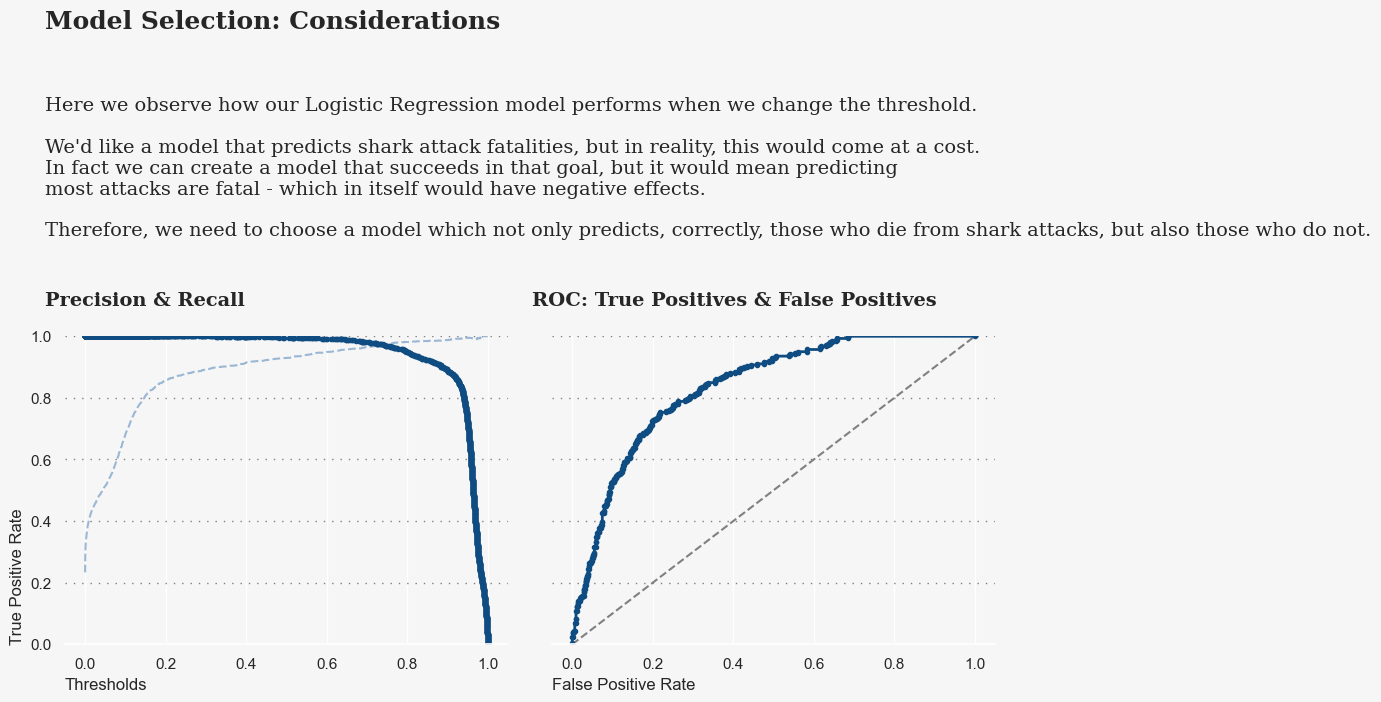

In [364]:
# source code: https://www.kaggle.com/ilyapozdnyakov/rain-in-australia-precision-recall-curves-viz
# https://www.kaggle.com/code/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5

ns_probs = [0 for _ in range(len(y_test_logreg))]
lr_probs = logreg_pipeline.predict_proba(x_test_logreg)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test_logreg, ns_probs)
lr_auc = roc_auc_score(y_test_logreg, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_logreg, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_logreg, lr_probs)

y_scores = logreg_pipeline.predict_proba(x_train_logreg)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train_logreg, y_scores)

# Plots

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, wspace=0.1,hspace=0)
ax = gs.subplots()

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))



y_scores = logreg_pipeline.predict_proba(x_train_logreg)[:,1]


precisions, recalls, thresholds = precision_recall_curve(y_train_logreg, y_scores)

ax[0].plot(thresholds, precisions[:-1], 'b--', label='Precision',color='#9bb7d4')
ax[0].plot(thresholds, recalls[:-1], '.', linewidth=1,label='Recall',color='#0f4c81')
ax[0].set_ylabel('True Positive Rate',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])


# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer',color='gray')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,color='#0f4c81')
ax[1].set_xlabel('False Positive Rate',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
    
    
ax[0].text(-0.1,2,'Model Selection: Considerations',fontsize=18,fontfamily='serif',fontweight='bold')
ax[0].text(-0.1,1.26,
'''
Here we observe how our Logistic Regression model performs when we change the threshold.

We'd like a model that predicts shark attack fatalities, but in reality, this would come at a cost.
In fact we can create a model that succeeds in that goal, but it would mean predicting
most attacks are fatal - which in itself would have negative effects.

Therefore, we need to choose a model which not only predicts, correctly, those who die from shark attacks, but also those who do not.
''',fontsize=14,fontfamily='serif')


ax[0].text(-0.1,1.1,'Precision & Recall',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].text(-0.1,1.1,'ROC: True Positives & False Positives',fontsize=14,fontfamily='serif',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)

plt.savefig('logistic-regression-thresholds-precision-recall.png', dpi=400)
plt.show()

## Tuning SVM

In [367]:
parameters = {'kernel':["rbf"],
              'C':[0.1, 1, 10, 100],
              'gamma': [1, 0.6, 0.4, 0.3, 0.1]}

svm = SVC(class_weight={0:1, 1:ratio_svm}, random_state=42)

grid = GridSearchCV(svm, parameters, cv=5, verbose=3, n_jobs=-1)

In [369]:
grid.fit(x_train_svm,y_train_svm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.766 total time= 1.7min
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.245 total time= 1.7min
[CV 5/5] END ......C=0.1, gamma=0.6, kernel=rbf;, score=0.356 total time= 1.7min
[CV 3/5] END ......C=0.1, gamma=0.4, kernel=rbf;, score=0.714 total time= 1.7min
[CV 5/5] END ......C=0.1, gamma=0.4, kernel=rbf;, score=0.705 total time= 1.7min
[CV 1/5] END ......C=0.1, gamma=0.6, kernel=rbf;, score=0.342 total time= 1.7min
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.769 total time= 1.7min
[CV 2/5] END ......C=0.1, gamma=0.4, kernel=rbf;, score=0.711 total time= 1.7min
[CV 2/5] END ......C=0.1, gamma=0.3, kernel=rbf;, score=0.755 total time= 1.5min
[CV 5/5] END ........C=1, gamma=0.6, kernel=rbf;, score=0.776 total time= 1.7min
[CV 4/5] END ........C=1, gamma=0.4, kernel=rbf;, score=0.822 total time= 1.6min
[CV 3/5] END .........C=10, gamma=1, kernel=rbf

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: 1, 1: 3.286206896551724},
                           random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.6, 0.4, 0.3, 0.1], 'kernel': ['rbf']},
             verbose=3)

In [370]:
grid.best_params_

{'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}

In [371]:
grid.best_score_

0.813557728279223

<div class='info'>

The best parameters for SVM (non-poly) are:

{'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}
</div>

In [381]:
"""
SVM (non-poly) Use the best parameters here
"""

#svm_pipeline = Pipeline(steps = [('SVM',SVC(class_weight={0:1, 1:ratio_svm},C=100, gamma=0.3, kernel='rbf',random_state=42))])
svm_pipeline = Pipeline(steps = [('SVM',SVC(class_weight={0:1, 1:ratio_svm}, kernel='rbf',random_state=42))])

svm_pipeline.fit(x_train_svm,y_train_svm)

svm_tuned_pred   = svm_pipeline.predict(x_test_svm)

In [382]:
print(classification_report(y_test_svm,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_svm,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test_svm,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       965
           1       0.55      0.75      0.64       279

    accuracy                           0.81      1244
   macro avg       0.74      0.79      0.75      1244
weighted avg       0.84      0.81      0.82      1244

Accuracy Score:  0.8086816720257235
F1 Score:  0.636085626911315


<div class='info'>
I ended up NOT using the optimized parameters because for a 2% gain in accuracy, we lost 10% in F1 score.
</div>

### Poly Kernel

In [387]:
'''
Let's try a search using the 'poly' kernel with RandomizedSearchCV

poly fit is computationally expensive therefore, not using GridSearchCV
'''
parameters = {'kernel':["poly"],
              'C':[0.1, 1, 10, 100],
              'gamma': [1, 0.6, 0.4, 0.3, 0.1],
              'degree': [2, 3, 4, 5, 6]}

svm = SVC(class_weight={0:1, 1:ratio_svm}, random_state=42)

grid = RandomizedSearchCV(svm, parameters, cv=5, verbose=3, refit=True, n_iter=10, n_jobs=8)

In [611]:
#grid.fit(x_train_svm,y_train_svm)

In [612]:
#grid.best_params_

In [613]:
#grid.best_score_

<div class='info'>

The best parameters for the poly kernel SVM (interrupted) are
C=0.1, degree=3, gamma=0.3, kernel=poly, score=0.819

</div>


In [390]:
"""
Poly: Use the best parameters here
"""

svm_poly_pipeline = Pipeline(steps = [('SVM',SVC(class_weight={0:1, 1:ratio_svm}, kernel='poly', random_state=42))])

svm_poly_pipeline.fit(x_train_svm,y_train_svm)

svm_poly_tuned_pred   = svm_poly_pipeline.predict(x_test_svm)

In [391]:
print(classification_report(y_test_svm,svm_poly_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test_svm,svm_poly_tuned_pred))
print('F1 Score: ',f1_score(y_test_svm,svm_poly_tuned_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       965
           1       0.58      0.63      0.60       279

    accuracy                           0.82      1244
   macro avg       0.74      0.75      0.74      1244
weighted avg       0.82      0.82      0.82      1244

Accuracy Score:  0.815112540192926
F1 Score:  0.603448275862069


## Naive Bayes

Threw in Naive Bayes for extra comparison.

In [655]:
ct = ColumnTransformer([('cat', OneHotEncoder(), categorical_features)])

X2_trans = ct.fit_transform(x).toarray()
            
x_train, x_test, y_train, y_test = train_test_split(X2_trans, target, test_size = 0.2, random_state=42)

In [657]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


# Create the Classifier
cls = GaussianNB()
cls2 = MultinomialNB()

# Train the model using the training sets
cls.fit(x_train, y_train)
cls2.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = cls.predict(x_test)
y_pred2 = cls2.predict(x_test)

In [659]:
print("GaussianNB:\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test,y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred)) 
print("ROC AUC: ", roc_auc_score(y_test, y_pred))

print("\n\nMultinomial NB:\n")
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("F1: ", f1_score(y_test,y_pred2))
print("Recall: ", recall_score(y_test, y_pred2))
print("Precision: ", precision_score(y_test, y_pred2)) 
print("ROC AUC: ", roc_auc_score(y_test, y_pred2))

GaussianNB:

Accuracy: 0.5144694533762058
F1:  0.43656716417910446
Recall:  0.8387096774193549
Precision:  0.29508196721311475
ROC AUC:  0.6297175330101956


Multinomial NB:

Accuracy: 0.8191318327974276
F1:  0.5302713987473904
Recall:  0.4551971326164875
Precision:  0.635
ROC AUC:  0.6897747321113525


<div class='info'>
MultinomialNB is the winner with an accuracy of 81.7%
</div>

## Model Comparison

In [464]:
# Make dataframes to plot


rf_df = pd.DataFrame(data=[f1_score(y_test_rf,rfc_tuned_pred),accuracy_score(y_test_rf, rfc_tuned_pred), recall_score(y_test_rf, rfc_tuned_pred),
                   precision_score(y_test_rf, rfc_tuned_pred), roc_auc_score(y_test_rf, rfc_tuned_pred)], 
             columns=['Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svm_df = pd.DataFrame(data=[f1_score(y_test_svm,svm_tuned_pred),accuracy_score(y_test_svm, svm_tuned_pred), recall_score(y_test_svm, svm_tuned_pred),
                   precision_score(y_test_svm, svm_tuned_pred), roc_auc_score(y_test_svm, svm_tuned_pred)], 
             columns=['SVM rbf Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
svm_poly_df = pd.DataFrame(data=[f1_score(y_test_svm,svm_poly_tuned_pred),accuracy_score(y_test_svm, svm_poly_tuned_pred), recall_score(y_test_svm, svm_poly_tuned_pred),
                   precision_score(y_test_svm, svm_poly_tuned_pred), roc_auc_score(y_test_svm, svm_poly_tuned_pred)], 
             columns=['SVM poly Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test_logreg,logreg_tuned_pred),accuracy_score(y_test_logreg, logreg_tuned_pred), recall_score(y_test_logreg, logreg_tuned_pred),
                   precision_score(y_test_logreg, logreg_tuned_pred), roc_auc_score(y_test_logreg, logreg_tuned_pred)], 
             columns=['Logistic Regression Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

nb_df = pd.DataFrame(data=[f1_score(y_test,y_pred2),accuracy_score(y_test, y_pred2), recall_score(y_test, y_pred2),
                   precision_score(y_test, y_pred2), roc_auc_score(y_test, y_pred2)], 
             columns=['Naive Bayes'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

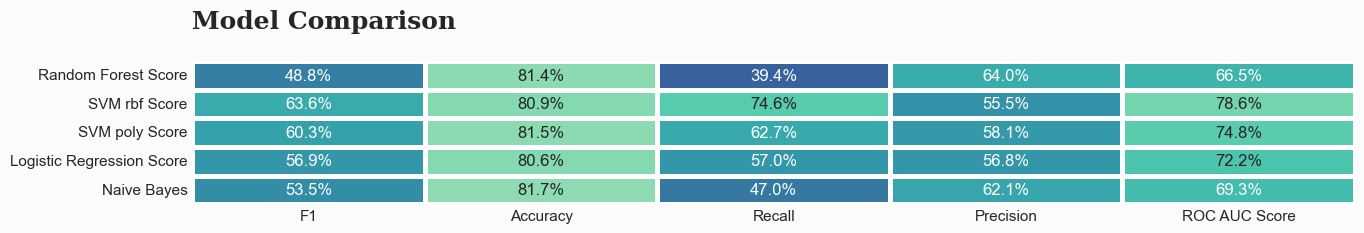

In [466]:
df_models = round(pd.concat([rf_df,svm_df,svm_poly_df, lr_df, nb_df], axis=1),5)

background_color = "#fbfbfb"
sns.set()
sns.set_palette(palette)

fig = plt.figure(figsize=(15,13)) # create figure
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=cmap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-1.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('model-comparison.png', dpi=400)
plt.show()

<div class='info'>
    
The best accuracy goes to Naive Bayes followd closely by SVM with the poly kernel.

<ul>
    <li>F1 goes to SVM with the rbf kernel</li>
    <li>Recall goes to SVM with the rbf kernel</li>
    <li>Precision goes to Random Forest</li>
    <li>ROC AUC goes to SVM with the rbf kernel</li>
</ul>
   
</div>

## Confusion Matrix

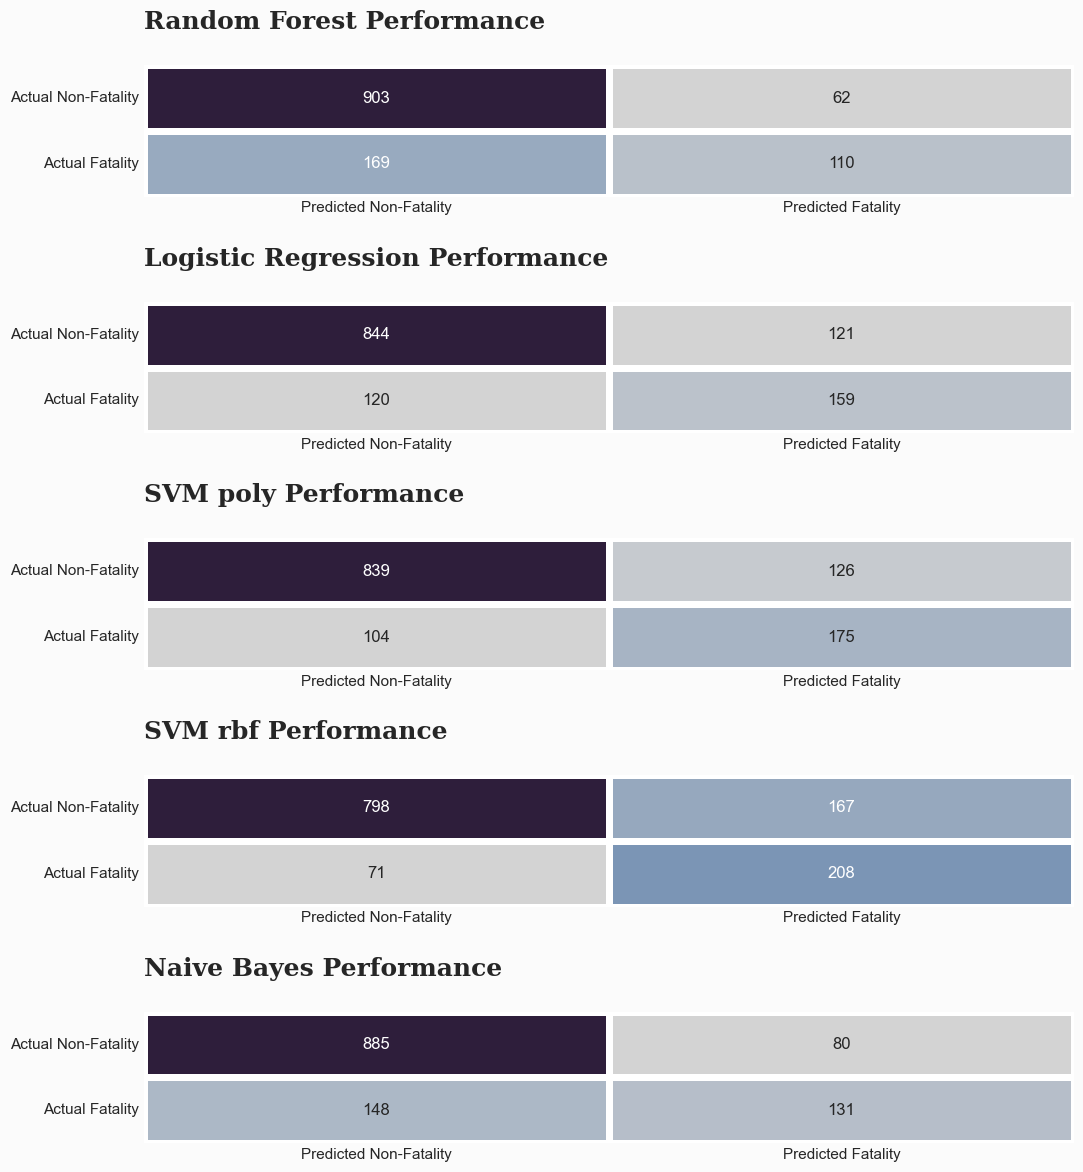

In [476]:
# Plotting our results
rf_cm  = confusion_matrix(y_test_rf,rfc_tuned_pred )
svm_cm = confusion_matrix(y_test_svm,svm_tuned_pred)
svm_poly_cm = confusion_matrix(y_test_svm,svm_poly_tuned_pred)
logreg_cm  = confusion_matrix(y_test_logreg,logreg_tuned_pred )
nb_cm  = confusion_matrix(y_test,y_pred2 )

#colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","'#37659e'"]
colors = palette_r.as_hex()[3:]
colors.insert(0, "lightgray")

colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


background_color = "#fbfbfb"

fig = plt.figure(figsize=(12,14)) # create figure
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])
ax4 = fig.add_subplot(gs[4, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Fatality','Actual Fatality'],xticklabels=['Predicted Non-Fatality','Predicted Fatality'],annot_kws={"fontsize":12})

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Fatality','Actual Fatality'],xticklabels=['Predicted Non-Fatality','Predicted Fatality'],annot_kws={"fontsize":12})

sns.heatmap(svm_poly_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Fatality','Actual Fatality'],xticklabels=['Predicted Non-Fatality','Predicted Fatality'],annot_kws={"fontsize":12})

sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax3,
            yticklabels=['Actual Non-Fatality','Actual Fatality'],xticklabels=['Predicted Non-Fatality','Predicted Fatality'],annot_kws={"fontsize":12})

sns.heatmap(nb_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax4,
            yticklabels=['Actual Non-Fatality','Actual Fatality'],xticklabels=['Predicted Non-Fatality','Predicted Fatality'],annot_kws={"fontsize":12})



ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color) 
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)
ax3.tick_params(axis=u'both', which=u'both',length=0)
ax3.set_facecolor(background_color)
ax4.tick_params(axis=u'both', which=u'both',length=0)
ax4.set_facecolor(background_color)

ax0.text(0,-0.55,'Random Forest Performance',fontsize=18,fontweight='bold',fontfamily='serif')

ax1.text(0,-0.55,'Logistic Regression Performance',fontsize=18,fontweight='bold',fontfamily='serif')

ax2.text(0,-0.55,'SVM poly Performance',fontsize=18,fontweight='bold',fontfamily='serif')

ax3.text(0,-0.55,'SVM rbf Performance',fontsize=18,fontweight='bold',fontfamily='serif')

ax4.text(0,-0.55,'Naive Bayes Performance',fontsize=18,fontweight='bold',fontfamily='serif')


plt.savefig('confusion-matrix.png', dpi=400)
plt.show()

<div class='info'>
<ul>
  <li>SVM rbf predicted the most Actual Fatality</li>   
    <li>Logistic Regression predicted the most Non-Fatality</li>
    <li>False Positives best was Random Forest while worst was SVM rbf</li>
    <li>False Negatives best was SVM rbf while worst was Random Forest</li>
</ul>
</div>

<div class='info'>
Overall the winner is the SVM models which need further tuning to increase accuracy while improving Precision and Recall.

The dataset is not large enough to warrant moving away from the computational cost of SVM.
</div>

## Feature Selection

### Random Forest

In [424]:
def feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_[:10]}).sort_values('Importance', ascending=False)

#print(x.columns.shape)
#print(rf_pipeline['RF'].feature_importances_.shape)

fi = feat_importance(rf_pipeline['RF'], x)
fi[:10].style.background_gradient(cmap=cmap_r)

,Feature,Importance
0,Activity,0.039819
3,Country,0.010833
9,Year,0.008089
7,Species,0.006581
6,Month Name,0.005597
2,Area,0.005197
5,Location,0.002139
1,Age,0.000585
4,Gender,0.000378
8,Type,0.000156


<div class='info'>

Random Forest chose Activity as the most important feature.  

</div>

<div class='info'>
    This makes sense intuitively because certain activity mimics prey behavior (splashing, kicking, floating, swimming)
</div>

<div class='info'>

Nearshore activities (surfing, wading), there are likely more witnesses to help get the victim to shore.

Offshore (paddling watercraft, jet ski), you are kinda on your own.

Open ocean, a rescue during a boating accident is a long time coming.
</div>

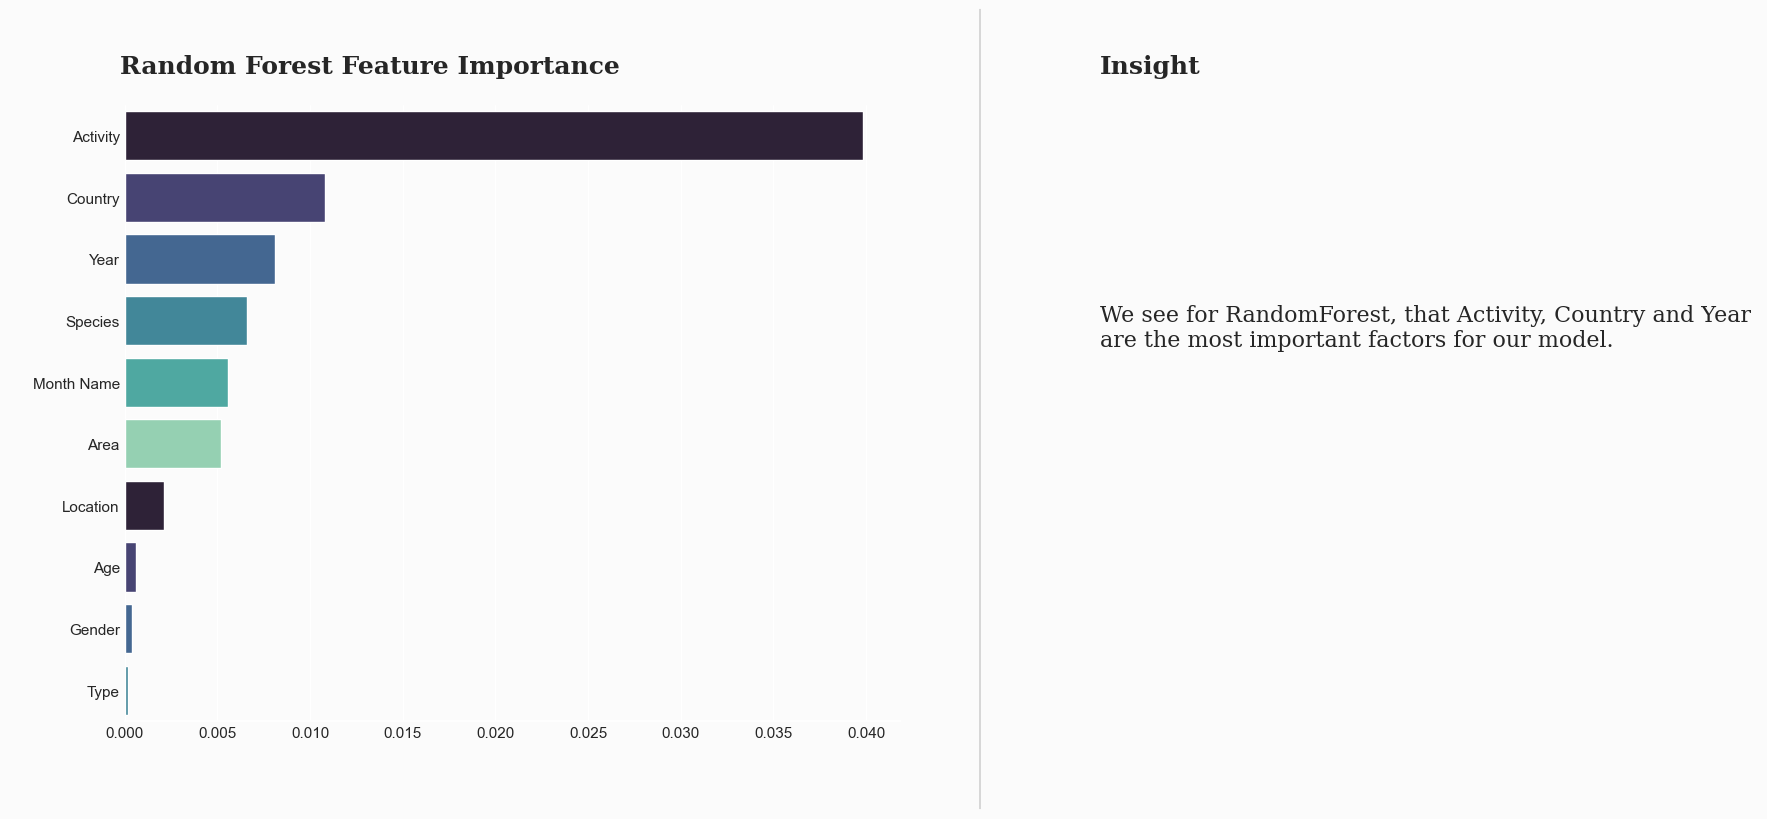

In [434]:
background_color = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)


sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=palette)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Random Forest Feature Importance", fontsize=18, fontweight='bold', fontfamily='serif')

    
plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')


fig.text(1.1, 0.92, 'Insight', fontsize=18, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.515, '''

We see for RandomForest, that Activity, Country and Year 
are the most important factors for our model.

'''
         , fontsize=16, fontweight='light', fontfamily='serif')

ax.tick_params(axis=u'both', which=u'both',length=0)


import matplotlib.lines as lines
l1 = lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.savefig('feature-importance.png', dpi=400)
plt.show()

### SVM

In [439]:
"""
Taking too long...

from sklearn.inspection import permutation_importance

# Compute permutation importance
results = permutation_importance(svm_pipeline, x_test_svm, y_test_svm, n_repeats=10, n_jobs=8, random_state=42)

for i, importance in enumerate(results.importances_mean):
    print(f"Feature {i+1}: {importance}")
"""

'\nTaking too long...\n\nfrom sklearn.inspection import permutation_importance\n\n# Compute permutation importance\nresults = permutation_importance(svm_pipeline, x_test_svm, y_test_svm, n_repeats=10, n_jobs=8, random_state=42)\n\nfor i, importance in enumerate(results.importances_mean):\n    print(f"Feature {i+1}: {importance}")\n'

## Improvements

Ways I would improve the F1 results are the following:

 - Geoencode the location data.
 - Classification of prey-like behavior (splashing, jumping, floating, swimming)
 - Classification of defensible activity (no protection vs protection from a surfboard or other watercraft)
 - Classification of rescue access (open ocean vs nearshore vs offshore)

## Conclusion

I was able to get the best model performance for prediction of shark attack fatality from SVM models. This was suprising, as I was expecting LogisticRegression or Random Forest to outperform SVM due to the extreme categorical nature of the data.

The data is apparently complex enough for the SVM models to outperform Logistic Regression and Random Forest.

Accuracy was in the low 80s and F1 in the low 60s.

